# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import Nystroem
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.base import clone
from sklearn import ensemble

# magic word for producing visualizations in notebook
%matplotlib inline

data_dir = 'arvato_data'
extra_attrs = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
now = datetime.datetime.now()

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [35]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', index_col=False)
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', index_col=False)

# # uncomment to save those DataFrames as .csv files in a folder
# azdias.to_csv(data_dir + '/Udacity_AZDIAS_052018.csv', sep=';', index=False)
# customers.to_csv(data_dir + '/Udacity_CUSTOMERS_052018.csv', sep=';', index=False)

In [396]:
# or load in the previously saved local data
azdias = pd.read_csv(data_dir + '/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv(data_dir + '/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\5ervant\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.



In [56]:
print('azdias dimension:', azdias.shape)

# display the data
azdias.head()

azdias dimension: (891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [397]:
print("customers with extra columns' dimension:", customers.shape)

# customers excluding 'CUSTOMER_GROUP', 'ONLINE_PURCHASE' and 'PRODUCT_GROUP' columns
customers_no_extra = customers.loc[:, ~customers.columns.isin(extra_attrs)]

print ('\nDisplay customers without extra columns:')
customers_no_extra.head()

customers with extra columns' dimension: (191652, 369)

Display customers without extra columns:


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


### Checking XML spreadsheets

Have a look on _"DIAS Information Levels - Attributes 2017.xlsx"_ and _"DIAS Attributes - Values 2017.xlsx"_ XML spreadsheets.  
It would be great if you can open them with a spreadsheet software, such as Microsoft Excel or Google Sheets.

In [398]:
# load in the data
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', index_col=None, header=1)
values_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', index_col=None, header=1)

# BUG: delete the auto-created 'Unnamed: 0' column
del attributes_df['Unnamed: 0']
del values_df['Unnamed: 0']

# prevent breaking of rows
pd.set_option('expand_frame_repr', False)

# display the data
print('attributes_df dimension:', attributes_df.shape)
print(attributes_df.head(), '\n')
print('values_df dimension:', values_df.shape)
print(values_df.head())

attributes_df dimension: (313, 4)
  Information level             Attribute                                        Description                                   Additional notes
0               NaN              AGER_TYP                                 best-ager typology  in cooperation with Kantar TNS; the informatio...
1            Person  ALTERSKATEGORIE_GROB                      age through prename analysis   modelled on millions of first name-age-referen...
2               NaN             ANREDE_KZ                                             gender                                                NaN
3               NaN         CJT_GESAMTTYP  Customer-Journey-Typology relating to the pref...  relating to the preferred information, marketi...
4               NaN     FINANZ_MINIMALIST         financial typology: low financial interest  Gfk-Typology based on a representative househo... 

values_df dimension: (2258, 4)
  Attribute         Description Value                     Meaning
0  

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Let's compare and display the descriptions of `azdias` and `customers` datasets:

In [399]:
# get the mean
azdias_mean = azdias.describe().loc['mean', :]
customers_no_extra_mean = customers_no_extra.describe().loc['mean', :]

# declare variable
min_attr_gap = 3

print('azdias_mean dimension:', azdias_mean.shape)
print(azdias_mean.head(), '\n')

print('customers_no_extra_mean dimension:', customers_no_extra_mean.shape)
print(customers_no_extra_mean.head())

azdias_mean dimension: (360,)
LNR            637263.000000
AGER_TYP           -0.358435
AKT_DAT_KL          4.421928
ALTER_HH           10.864126
ALTER_KIND1        11.745392
Name: mean, dtype: float64 

customers_no_extra_mean dimension: (360,)
LNR            95826.500000
AGER_TYP           0.344359
AKT_DAT_KL         1.747525
ALTER_HH          11.352009
ALTER_KIND1       12.337243
Name: mean, dtype: float64


Here we will get the high gap attributes between `azdias` and `customers`:

In [252]:
customers_azdias_high_gap_attrs = []

for i, item in customers_no_extra_mean.iteritems():
    azdias_mean_item = azdias_mean[i]
    gap = abs(azdias_mean_item - item)
    
    if (gap >= min_attr_gap and i != 'LNR'):
        print("gap: {} | attr: {} | azdias' val: {} | customers' val: {}".format(gap, i, azdias_mean_item, item))
        customers_azdias_high_gap_attrs.append(i)

print('\ncustomers_azdias_high_gap_attrs:', customers_azdias_high_gap_attrs)
print('Length:', len(customers_azdias_high_gap_attrs))

gap: 3.369137995421216 | attr: ALTERSKATEGORIE_FEIN | azdias' val: 13.70071656633889 | customers' val: 10.331578570917674
gap: 3.3213997272377185 | attr: ANZ_HAUSHALTE_AKTIV | azdias' val: 8.28726319522149 | customers' val: 4.965863467983771
gap: 4.544008062817511 | attr: EINGEZOGENAM_HH_JAHR | azdias' val: 2003.7290607321315 | customers' val: 1999.185052669314
gap: 5.0802070439637035 | attr: EXTSEL992 | azdias' val: 33.338392359997975 | customers' val: 38.41859940396168
gap: 97.7857999361321 | attr: GEBURTSJAHR | azdias' val: 1101.178532597414 | customers' val: 1003.3927326612819
gap: 47.529776748614154 | attr: KBA13_ANZAHL_PKW | azdias' val: 619.7014391008134 | customers' val: 667.2312158494276
gap: 3.5589335696132007 | attr: LP_LEBENSPHASE_FEIN | azdias' val: 14.622637124351426 | customers' val: 18.181570693964627
gap: 3.906072643824456 | attr: PRAEGENDE_JUGENDJAHRE | azdias' val: 8.154345555142887 | customers' val: 4.248272911318431

customers_azdias_high_gap_attrs: ['ALTERSKATEGOR

In [7]:
# display a description of the dataset
azdias[customers_azdias_high_gap_attrs].describe()

,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,EINGEZOGENAM_HH_JAHR,EXTSEL992,GEBURTSJAHR,KBA13_ANZAHL_PKW,LP_LEBENSPHASE_FEIN,PRAEGENDE_JUGENDJAHRE
count,628274.000000,798073.000000,817722.000000,237068.000000,891221.000000,785421.000000,886367.000000,891221.000000
mean,13.700717,8.287263,2003.729061,33.338392,1101.178533,619.701439,14.622637,8.154346
std,5.079849,15.628087,7.058204,14.537408,976.583551,340.034318,12.616883,4.844532
min,0.000000,0.000000,1900.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,1.000000,1997.000000,23.000000,0.000000,384.000000,4.000000,5.000000
50%,14.000000,4.000000,2003.000000,34.000000,1943.000000,549.000000,11.000000,8.000000
75%,17.000000,9.000000,2010.000000,43.000000,1970.000000,778.000000,27.000000,14.000000
max,25.000000,595.000000,2018.000000,56.000000,2017.000000,2300.000000,40.000000,15.000000


In [132]:
# display a description of the dataset
customers[customers_azdias_high_gap_attrs].describe()

,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,EINGEZOGENAM_HH_JAHR,EXTSEL992,GEBURTSJAHR,KBA13_ANZAHL_PKW,LP_LEBENSPHASE_FEIN,PRAEGENDE_JUGENDJAHRE
count,139810.000000,141725.000000,145056.000000,106369.000000,191652.000000,140371.000000,188439.000000,191652.000000
mean,10.331579,4.965863,1999.185053,38.418599,1003.392733,667.231216,18.181571,4.248273
std,4.134828,14.309694,6.178099,13.689466,974.531081,340.481722,15.009985,3.807671
min,0.000000,0.000000,1986.000000,1.000000,0.000000,5.000000,0.000000,0.000000
25%,9.000000,1.000000,1994.000000,29.000000,0.000000,430.000000,0.000000,0.000000
50%,10.000000,1.000000,1997.000000,36.000000,1926.000000,593.000000,16.000000,4.000000
75%,13.000000,4.000000,2004.000000,53.000000,1949.000000,828.000000,36.000000,6.000000
max,25.000000,523.000000,2018.000000,56.000000,2017.000000,2300.000000,40.000000,15.000000


Here are the high gap attributes for `purchasers_mean` *(mean for customers that purchased)* and `azdias_mean`:

In [400]:
# select all the customers that purchased
purchasers = customers.loc[customers['ONLINE_PURCHASE'] > 0]

# exclude the extra attributes
purchasers_no_extra = purchasers.loc[:, ~purchasers.columns.isin(extra_attrs)]

# get the mean
purchasers_no_extra_mean = purchasers_no_extra.describe().loc['mean', :]


purchasers_azdias_high_gap_attrs = []

for i, item in purchasers_no_extra_mean.iteritems():
    azdias_mean_item = azdias_mean[i]
    gap = abs(azdias_mean_item - item)
    
    if (gap >= min_attr_gap and i != 'LNR'):
        print("gap: {} | attr: {} | azdias' val: {} | purchasers' val: {}".format(gap, i, azdias_mean_item, item))
        purchasers_azdias_high_gap_attrs.append(i)

print('\npurchasers_azdias_high_gap_attrs:', purchasers_azdias_high_gap_attrs)
print('Length:', len(purchasers_azdias_high_gap_attrs))

gap: 3.6350069812520687 | attr: ALTER_HH | azdias' val: 10.864126194476851 | purchasers' val: 14.49913317572892
gap: 3.579048127505976 | attr: ANZ_HAUSHALTE_AKTIV | azdias' val: 8.28726319522149 | purchasers' val: 4.708215067715514
gap: 3.286891678930277 | attr: ANZ_STATISTISCHE_HAUSHALTE | azdias' val: 7.599356199244931 | purchasers' val: 4.312464520314654
gap: 84.9084817411615 | attr: GEBURTSJAHR | azdias' val: 1101.178532597414 | purchasers' val: 1186.0870143385755
gap: 51.940587134645625 | attr: KBA13_ANZAHL_PKW | azdias' val: 619.7014391008134 | purchasers' val: 671.6420262354591
gap: 4.035533348923826 | attr: LP_LEBENSPHASE_FEIN | azdias' val: 14.622637124351426 | purchasers' val: 18.658170473275252

purchasers_azdias_high_gap_attrs: ['ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'LP_LEBENSPHASE_FEIN']
Length: 6


We can see that the attributes "GEBURTSJAHR" and "KBA13_ANZAHL_PKW" have the highest gaps even we did not exclude all the rows that have a `NaN` value in those columns on our data.

The following are the common high gap attribute descriptions between `customers_azdias_high_gap_attrs` and `purchasers_azdias_high_gap_attrs`:

In [255]:
# get the attributes that are in both arrays
common_high_gap_attrs = np.intersect1d(customers_azdias_high_gap_attrs, purchasers_azdias_high_gap_attrs)

for i, row in attributes_df.iterrows():
    for item in np.nditer(common_high_gap_attrs):
        if (row['Attribute'] == item):
            print('   Attribute: "{}" | Description: "{}"'.format(item, row.Description))
            print(" >> for customers:\n{}".format(customers[item].describe()))
            print(" >> azdias:\n{}\n".format(azdias[item].describe()))

   Attribute: "GEBURTSJAHR" | Description: "year of birth"
 >> for customers:
count    191652.000000
mean       1003.392733
std         974.531081
min           0.000000
25%           0.000000
50%        1926.000000
75%        1949.000000
max        2017.000000
Name: GEBURTSJAHR, dtype: float64
 >> azdias:
count    891221.000000
mean       1101.178533
std         976.583551
min           0.000000
25%           0.000000
50%        1943.000000
75%        1970.000000
max        2017.000000
Name: GEBURTSJAHR, dtype: float64

   Attribute: "LP_LEBENSPHASE_FEIN" | Description: "lifestage fine"
 >> for customers:
count    188439.000000
mean         18.181571
std          15.009985
min           0.000000
25%           0.000000
50%          16.000000
75%          36.000000
max          40.000000
Name: LP_LEBENSPHASE_FEIN, dtype: float64
 >> azdias:
count    886367.000000
mean         14.622637
std          12.616883
min           0.000000
25%           4.000000
50%          11.000000
75%       

### Data Visualisation

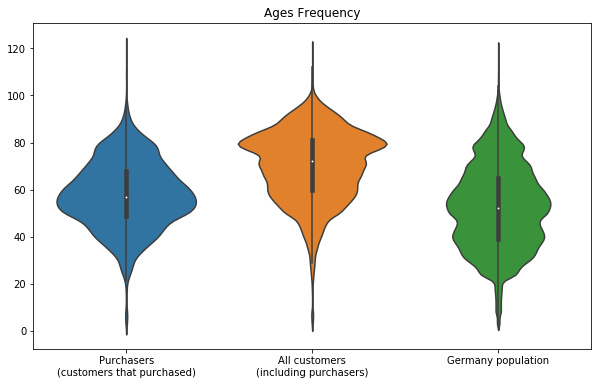

In [256]:
xlabels = [
    'Purchasers\n(customers that purchased)',
    'All customers\n(including purchasers)',
    'Germany population'
]

def get_ages_from_data(data):
    birth_years = data['GEBURTSJAHR']
    birth_years = birth_years[~(birth_years == 0)] # remove the years that have a value of 0
    return birth_years.apply(lambda x: now.year - x) # convert birth years to ages

purchasers_age = get_ages_from_data(purchasers)
customers_age = get_ages_from_data(customers)
azdias_age = get_ages_from_data(azdias)

plt.figure(figsize=(10,6))
plt.title("Ages Frequency")

ax = sns.violinplot(data=[purchasers_age, customers_age, azdias_age])\
    .set_xticklabels(xlabels)

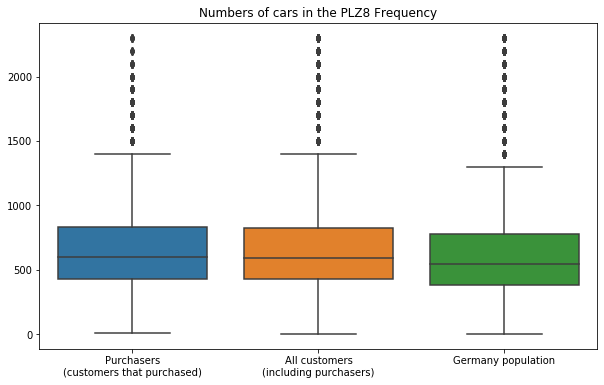

In [257]:
purchasers_car_num = purchasers['KBA13_ANZAHL_PKW']
customers_car_num = customers['KBA13_ANZAHL_PKW']
azdias_car_num = azdias['KBA13_ANZAHL_PKW']

plt.figure(figsize=(10,6))
plt.title("Numbers of cars in the PLZ8 Frequency")

ax = sns.boxplot(data=[purchasers_car_num, customers_car_num, azdias_car_num])\
    .set_xticklabels(xlabels)

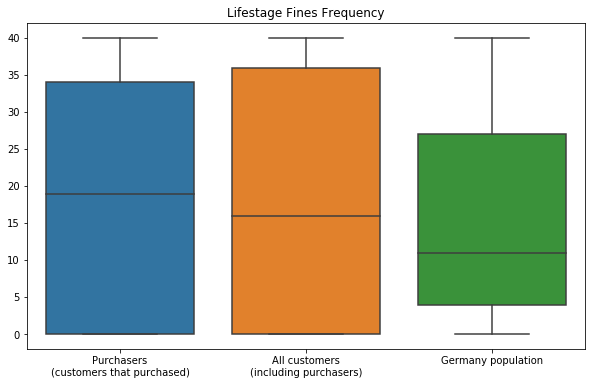

In [258]:
purchasers_lifestage_fine = purchasers['LP_LEBENSPHASE_FEIN']
customers_lifestage_fine = customers['LP_LEBENSPHASE_FEIN']
azdias_lifestage_fine = azdias['LP_LEBENSPHASE_FEIN']

plt.figure(figsize=(10,6))
plt.title("Lifestage Fines Frequency")

ax = sns.boxplot(data=[purchasers_lifestage_fine, customers_lifestage_fine, azdias_lifestage_fine])\
    .set_xticklabels(xlabels)

### K-Means Clustering

Since the attributes about _"year of birth", "number of cars in the PLZ8"_ and _"lifestage fine"_ are our top three highest mean gaps between our demographics datas, they are the good candidates for training our k-means model.

There are very common and useful segmentation methods as well. One of them is called RFM which stands for Recency-Frequency-Monetary Value.

In [401]:
# num of rows to clear for the training data
X_row_num = 2000

def select_kmeans_x(data):
    attrs = ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'LP_LEBENSPHASE_FEIN']
    
    if 'ONLINE_PURCHASE' in data:
        attrs.append('ONLINE_PURCHASE')
    
    # select few attributes
    X = data[attrs][:X_row_num] # select few rows to proceed fast
    
    # fill all NaN with 0 to fix the
    # "ValueError: Input contains NaN, infinity or a value too large for dtype('float64')."
    X = X.fillna(0)
    
    X = X[X['GEBURTSJAHR'] > 0] # only select the rows that have a birth year greater than 0
    birth_years = X['GEBURTSJAHR']
    X['GEBURTSJAHR'] = birth_years.apply(lambda x: now.year - x) # convert birth years to ages
    return X

X = select_kmeans_x(azdias)
print('X dimension:', X.shape)

# display the datasets
print(X.head())

X dimension: (1029, 3)
   GEBURTSJAHR  KBA13_ANZAHL_PKW  LP_LEBENSPHASE_FEIN
1           24             963.0                 21.0
2           41             712.0                  3.0
3           63             596.0                  0.0
4           57             435.0                 32.0
5           77            1300.0                  8.0


In [384]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

x = list(range(2, 12))
y_std = []

for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300)
    kmeans.fit(X)
    
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    
    y_std.append(silhouette_avg)
    print("The average silhouette_score is: {} with Std Scaling".format(silhouette_avg))

n_clusters = 2
The average silhouette_score is: 0.5895090131239678 with Std Scaling
n_clusters = 3
The average silhouette_score is: 0.5114030166331367 with Std Scaling
n_clusters = 4
The average silhouette_score is: 0.5153760510006951 with Std Scaling
n_clusters = 5
The average silhouette_score is: 0.5042758137060444 with Std Scaling
n_clusters = 6
The average silhouette_score is: 0.4904305148601132 with Std Scaling
n_clusters = 7
The average silhouette_score is: 0.504462888818358 with Std Scaling
n_clusters = 8
The average silhouette_score is: 0.5108317056721349 with Std Scaling
n_clusters = 9
The average silhouette_score is: 0.4946813163896397 with Std Scaling
n_clusters = 10
The average silhouette_score is: 0.477456854958478 with Std Scaling
n_clusters = 11
The average silhouette_score is: 0.4752489866361168 with Std Scaling


As you can see, the highest average `silhouette_score` is at the `n_clusters` of 2. We will train our k-means model with `n_clusters=2` and use that model to predict our training features to get the clusters for visualization:

In [402]:
# # uncomment to install plotly
# conda install -c plotly plotly=4.5.0

import plotly as py
import plotly.graph_objs as go

def clusters_3d(n_clusters, data, attrs, title):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300)
    kmeans.fit(data)
    clusters = kmeans.predict(data) # [0, n < n_clusters, n < n_clusters, etc...]

    data['clusters'] = clusters

    # display the data
    print(data.head())

    trace1 = go.Scatter3d(
        x = data[attrs[0]['index']],
        y = data[attrs[1]['index']],
        z = data[attrs[2]['index']],
        mode = 'markers',
        marker = {
            'color': data['clusters'],
            'size': 20,
            'line': {
                'color': data['clusters'],
                'width': 12
            },
            'opacity': 0.8
        }
    )
    data = [trace1]
    layout = go.Layout(
        height = 600,
        title = title,
        scene = {
            'xaxis': { 'title': attrs[0]['title'] },
            'yaxis': { 'title': attrs[1]['title'] },
            'zaxis': { 'title': attrs[2]['title'] }
        }
    )
    fig = go.Figure(data=data, layout=layout)

    py.offline.iplot(fig)
    return kmeans

In [389]:
attrs = [{
    'index': 'GEBURTSJAHR',
    'title': 'Age'
}, {
    'index': 'KBA13_ANZAHL_PKW',
    'title': 'Number of cars'
}, {
    'index': 'LP_LEBENSPHASE_FEIN',
    'title': 'Lifestage fine'
}]

kmeans_model = clusters_3d(2, X, attrs, 'Germany Population Clusters')

   GEBURTSJAHR  KBA13_ANZAHL_PKW  LP_LEBENSPHASE_FEIN  clusters
1           24             963.0                 21.0         1
2           41             712.0                  3.0         0
3           63             596.0                  0.0         0
4           57             435.0                 32.0         0
5           77            1300.0                  8.0         1


Since `n_clusters` of 2 just divided our dataset into 2 clusters, we can increase it around 4 *(average silhouette_score: 0.5153760510006951 with Std Scaling)* to have a better view.

In [390]:
kmeans_model = clusters_3d(4, X, attrs, 'Germany Population Clusters')

   GEBURTSJAHR  KBA13_ANZAHL_PKW  LP_LEBENSPHASE_FEIN  clusters
1           24             963.0                 21.0         3
2           41             712.0                  3.0         2
3           63             596.0                  0.0         2
4           57             435.0                 32.0         2
5           77            1300.0                  8.0         0


### Custom Visualization

Here we will create a 3D graph of `customers` where we can see which bought online or not:

In [403]:
customers_X = select_kmeans_x(customers)

# display the dataset
print(customers_X.head(), '\n')

trace1 = go.Scatter3d(
    x = customers_X[attrs[0]['index']],
    y = customers_X[attrs[1]['index']],
    z = customers_X[attrs[2]['index']],
    mode = 'markers',
    marker = {
        'color': customers_X['ONLINE_PURCHASE'],
        'size': 20,
        'line': {
            'color': customers_X['ONLINE_PURCHASE'],
            'width': 12
        },
        'opacity': 0.8
    }
)
data = [trace1]
layout = go.Layout(
    height = 600,
    title = "Customer 'ONLINE_PURCHASE' Groups",
    scene = {
        'xaxis': { 'title': attrs[0]['title'] },
        'yaxis': { 'title': attrs[1]['title'] },
        'zaxis': { 'title': attrs[2]['title'] }
    }
)
fig = go.Figure(data=data, layout=layout)

# display a description of the dataset
print(customers_X.describe())

py.offline.iplot(fig)

   GEBURTSJAHR  KBA13_ANZAHL_PKW  LP_LEBENSPHASE_FEIN  ONLINE_PURCHASE
4           60             513.0                 31.0                0
6           78            1300.0                 20.0                0
7           82             481.0                 20.0                0
8          106             428.0                  6.0                0
9           61            1106.0                 28.0                0 

       GEBURTSJAHR  KBA13_ANZAHL_PKW  LP_LEBENSPHASE_FEIN  ONLINE_PURCHASE
count   733.000000        733.000000           733.000000       733.000000
mean     68.724420        692.826739            23.821282         0.107776
std      15.881233        376.281666            12.900713         0.310309
min       3.000000          0.000000             0.000000         0.000000
25%      58.000000        456.000000            13.000000         0.000000
50%      71.000000        598.000000            25.000000         0.000000
75%      80.000000        889.000000           

Only 10.78% _(0.107776 * 100, yellow)_ of our cleared 733 `customers` which bought online.

### Customize selected train/test data

If we will going to reconstruct our own training and test features and their corresponding class labels, we can try to extract those this way:

In [19]:
customers_extra = customers[extra_attrs]

# display a description of the dataset
customers_extra.describe()

,ONLINE_PURCHASE
count,191652.000000
mean,0.090247
std,0.286536
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


We can use the 'ONLINE_PURCHASE' column values as our class labels and all the other columns' values as our features excluding the 'CUSTOMER_GROUP', 'ONLINE_PURCHASE' and 'PRODUCT_GROUP' columns for our training and test class labels and features if we want to train a model that can predict whether a person might purchase online or not.

In [20]:
# function generates train and test features and class labels
def train_test_data(df, excepted_attributes, selected_label, test_size=0.2):
    X = df.loc[:, ~df.columns.isin(excepted_attributes)]
    y = df[selected_label]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test

In [21]:
# make the 'ONLINE_PURCHASE' column values as class labels
selected_label = 'ONLINE_PURCHASE'

# make all the attributes as features except the customers extra attributes
X_train, X_test, y_train, y_test = train_test_data(customers, extra_attrs, selected_label)

print('X_train dimension: {}, y_train dimension: {}'.format(X_train.shape, y_train.shape))
print('X_test dimension: {}, y_test dimension: {}'.format(X_test.shape, y_test.shape))

X_train dimension: (153321, 366), y_train dimension: (153321,)
X_test dimension: (38331, 366), y_test dimension: (38331,)


In [22]:
# display X_train
X_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
23876,2076,-1,6.0,14.0,NaN,NaN,NaN,NaN,14.0,1.0,...,4.0,6.0,3.0,2.0,4.0,4.0,1.0,3,1,4
98228,145407,2,1.0,13.0,NaN,NaN,NaN,NaN,12.0,2.0,...,0.0,5.0,4.0,2.0,6.0,9.0,4.0,1,1,3
151061,163685,-1,1.0,16.0,NaN,NaN,NaN,NaN,16.0,1.0,...,3.0,7.0,9.0,6.0,3.0,9.0,2.0,3,2,3
91991,186024,2,1.0,19.0,NaN,NaN,NaN,NaN,13.0,2.0,...,2.0,3.0,6.0,4.0,3.0,9.0,4.0,4,1,3
115254,66018,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,9.0,...,4.0,6.0,9.0,11.0,6.0,9.0,4.0,3,2,4


In [23]:
# display y_train
y_train.head()

23876     0
98228     1
151061    1
91991     0
115254    0
Name: ONLINE_PURCHASE, dtype: int64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [89]:
# # load in the data
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', index_col=False)

# # uncomment to save it as .csv file in a folder
# mailout_train.to_csv(data_dir + '/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', index=False)

In [3]:
# or load in the previously saved local data
mailout_train = pd.read_csv(data_dir + '/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\5ervant\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
print('mailout_train dimension:', mailout_train.shape)

# display the data
mailout_train.head()

mailout_train dimension: (42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


The code that you will see tests some incompatible values on our training dataset, whenever there's an incompatible value I will test it using following code:

In [770]:
for i, row in X.iterrows():
    for item in row.iteritems():
#         if (isinstance(item[1], str)): # inaccurate to be used
#             print(i, item) # first found: 'CAMEO_DEU_2015'
#             break
        if (item[1] == 'W'):
            print(i, item)
            break
        if (item[1] == '1992-02-10 00:00:00'):
            print(i, item)
            break
        if (item[1] == 'D19_UNBEKANNT'):
            print(i, item)
            break
        if (item[1] == '4A'):
            print(i, item)
            break
        if (item[1] == 'XX'):
            print(i, item)
            break
        if (item[1] == 'X'):
            print(i, item)
            break

These functions do the work to clear and encode some incompatible values on our training dataset:

In [4]:
# string attributes to encode to their unique numeric values
str_attrs = [
    'OST_WEST_KZ', # flag strings
    'D19_LETZTER_KAUF_BRANCHE', # string values
    'CAMEO_DEU_2015' # 2-char strings
]

# function cleans train and test features
def clear_features(data):
    # fill all NaN with 0 to fix the
    # "ValueError: Input contains NaN, infinity or a value too large for dtype('float64')."
    data = data.fillna(0)
    print('All NaN values are now converted to 0.')
    
    for attr in str_attrs:
        if attr in data.columns:
            print(" - Previous column:\n{}".format(data[attr].head()))
            data = encode_data_str_col(data, attr)
            print(" - New column:\n{}\n".format(data[attr].head()))
    
    if 'EINGEFUEGT_AM' in data.columns:
        print(" - Previous column:\n{}".format(data['EINGEFUEGT_AM'].head()))
        # encode date strings with numbers of days in-between
        data['EINGEFUEGT_AM'] = data['EINGEFUEGT_AM'].apply(convert_date_to_days)
        print(" - New column:\n{}\n".format(data['EINGEFUEGT_AM'].head()))
    
    if (data.columns.isin(['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']).any()):
        # replace all 'XX' and 'X' values with NaN
        if 'CAMEO_INTL_2015' in data.columns:
            data['CAMEO_INTL_2015'].replace(['XX'], [0], inplace=True)
            print("'XX' values are now replaced by NaN.")
        if 'CAMEO_DEUG_2015' in data.columns:
            data['CAMEO_DEUG_2015'].replace(['X'], [0], inplace=True)
            print("'X' values are now replaced by NaN.")
        print()
    
    return data

# encode column string values with numerical values
def encode_data_str_col(data, attr):
    unique_vals = data[attr].unique()
    unique_str = [s for s in unique_vals if isinstance(s, str)]

    nums = range(1, len(unique_str) + 1)
    data[attr].replace(unique_str, nums, inplace=True)
    
    print('  >> Number of unique column strings:', len(unique_str))
    print('  >> {} have been encoded to {}.'.format(unique_str, nums))
    return data

def convert_date_to_days(x):
    return (now - datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).days if isinstance(x, str) else x

### Filter Method - Pearson correlation

I divided `mailout_train` columns to have our own training features and their corresponding class labels and use Pearson correlation.

> Earlier, I tried to use the Nystroem method to speed up the process but it seems that the computed pairwise correlation of columns are not that effective to use for getting the highly correlated features.

All NaN values are now converted to 0.
 - Previous column:
0    W
1    W
2    O
3    W
4    W
Name: OST_WEST_KZ, dtype: object
  >> Number of unique column strings: 2
  >> ['W', 'O'] have been encoded to range(1, 3).
 - New column:
0    1
1    1
2    2
3    1
4    1
Name: OST_WEST_KZ, dtype: int64

 - Previous column:
0         D19_UNBEKANNT
1      D19_TELKO_MOBILE
2      D19_LEBENSMITTEL
3         D19_UNBEKANNT
4    D19_BEKLEIDUNG_GEH
Name: D19_LETZTER_KAUF_BRANCHE, dtype: object
  >> Number of unique column strings: 35
  >> ['D19_UNBEKANNT', 'D19_TELKO_MOBILE', 'D19_LEBENSMITTEL', 'D19_BEKLEIDUNG_GEH', 'D19_BUCH_CD', 'D19_NAHRUNGSERGAENZUNG', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_HAUS_DEKO', 'D19_FREIZEIT', 'D19_ENERGIE', 'D19_VOLLSORTIMENT', 'D19_BANKEN_REST', 'D19_VERSICHERUNGEN', 'D19_KINDERARTIKEL', 'D19_TECHNIK', 'D19_DROGERIEARTIKEL', 'D19_BEKLEIDUNG_REST', 'D19_WEIN_FEINKOST', 'D19_HANDWERK', 'D19_GARTEN', 'D19_BANKEN_DIREKT', 'D19_DIGIT_SERV', 'D19_REISEN', 'D19_SAMMELARTIKEL', 

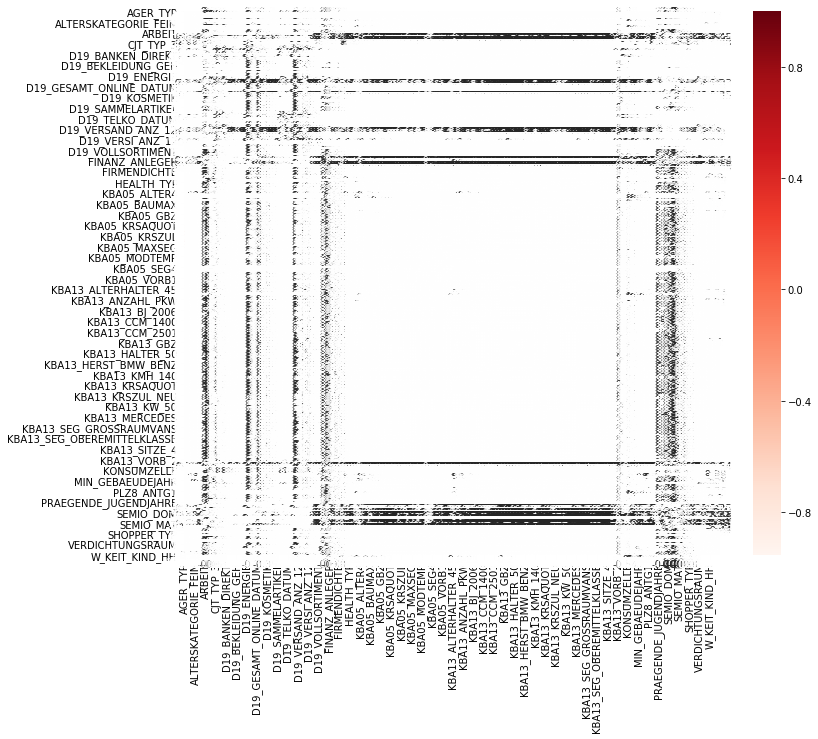

In [5]:
X = clear_features(mailout_train)
y = mailout_train['RESPONSE']
del X['LNR']
# don't forget to `del X['RESPONSE']` on an actual training

# # but not effective for computing the pairwise correlation of columns
# print('Using the Nystroem method to speed up kernel machines...')
# feature_map_nystroem = Nystroem(n_components=X.shape[1])
# X2 = feature_map_nystroem.fit_transform(X)
# X = pd.DataFrame(X2, columns=X.columns) # convert back to DataFrame
# print(X.head(), '\n')

# using Pearson correlation
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.plot()
plt.show()

Here's some testing of minimum correlation targets to see how many relevant features will produce when we set `min_cor_target` to this or that:

In [8]:
# minimum correlation targets to test
min_cor_targets = [
    # custom
#     0.0010, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.0040, 0.0045,
#     0.005, 0.006, 0.007, 0.008, 0.009,
    0.010, 0.011, 0.012, 0.013, 0.0136,
    0.015, 0.0155, 0.01584, 0.016, 0.0165, 0.017, 0.020,
    0.030, 0.031, 0.035,
    
#     # correlation target description values
#     0.005359, 0.004708, 0.000055, 0.002178, 0.004217, 0.007067, 0.040392,
]

# correlation with output variable
cor_target = abs(cor["RESPONSE"]).drop('RESPONSE')

print('Correlation target (w/o "RESPONSE") description:\n{}\n'.format(cor_target.describe()))

for min_cor_target in min_cor_targets:
    print(' - Minimum correlation target: {:.10f}'.format(min_cor_target))
    
    # selecting highly correlated features
    relevant_features = cor_target[cor_target >= min_cor_target]
    
    print(' - Number of relevant features:', len(relevant_features))
    print(' - Relevant features:\n{}\n'.format(relevant_features))

Correlation target (w/o "RESPONSE") description:
count    363.000000
mean       0.005359
std        0.004708
min        0.000055
25%        0.002178
50%        0.004217
75%        0.007067
max        0.040392
Name: RESPONSE, dtype: float64

 - Minimum correlation target: 0.0100000000
 - Number of relevant features: 46
 - Relevant features:
AGER_TYP                 0.013432
AKT_DAT_KL               0.012428
ANZ_TITEL                0.010388
CJT_GESAMTTYP            0.011814
CJT_KATALOGNUTZER        0.010132
CJT_TYP_1                0.011729
CJT_TYP_2                0.011846
CJT_TYP_3                0.012673
CJT_TYP_4                0.013463
CJT_TYP_5                0.013710
CJT_TYP_6                0.012244
D19_BANKEN_DIREKT        0.015849
D19_BANKEN_LOKAL         0.010745
D19_KINDERARTIKEL        0.011022
D19_KONSUMTYP            0.029731
D19_KONSUMTYP_MAX        0.040392
D19_RATGEBER             0.010270
D19_SCHUHE               0.010472
D19_SOZIALES             0.031280
D19_TIERARTI

I test different classifiers and tune a few parameters and compute the accuracies and the Area Under the Receiver Operating Characteristic Curves (ROC AUC) from probability prediction scores of the evaluating models using this complex code that I build. One run will evaluate different kinds of models and train them with different sizes of features based on the listed minimum correlation targets:

test_size: 0.2

All NaN values are now converted to 0.
Number of relevant features: 10
X_train dimension: (34369, 10) | y_train dimension: (34369,)
X_test dimension: (8593, 10) | y_test dimension: (8593,)

models_arr[0][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.02434004 0.01500523 0.00493631 0.00928745 0.00465856 0.02279073
 0.00928745 0.01676939 0.02854515 0.

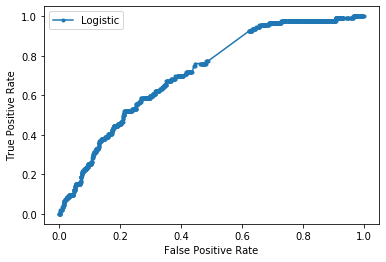

models_arr[0][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01118684 0.00618859 0.00758489 0.02251804 0.00522977 0.01120658
 0.02251804 0.0092989  0.02047455 0.01002899]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0150000000
Accuracy: 98.9293611078785% | ROC AUC: 0.6676068800090015


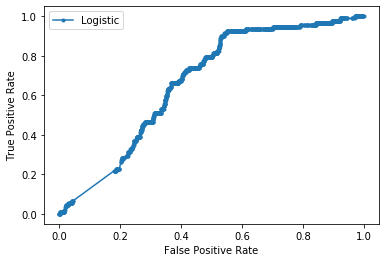

models_arr[0][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.         0.         0.         0.03493702
 0.         0.         0.         0.        ]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0150000000
Accuracy: 98.9293611078785% | ROC AUC: 0.488796075142055


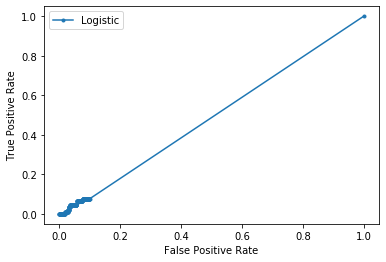

models_arr[0][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.48265644 0.48124538 0.46943902 0.47747553 0.47316669 0.48383961
 0.47747553 0.48187821 0.48273862 0.48608865]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0150000000
Accuracy: 98.9293611078785% | ROC AUC: 0.7573904348848984


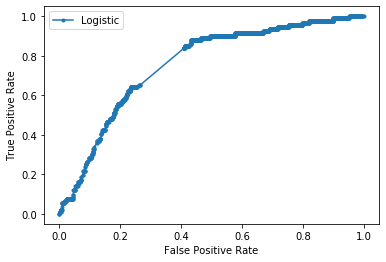

models_arr[0][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.         0.011001   0.         0.03390323
 0.011001   0.         0.06190476 0.        ]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0150000000
Accuracy: 98.73152566042127% | ROC AUC: 0.5941935219897403


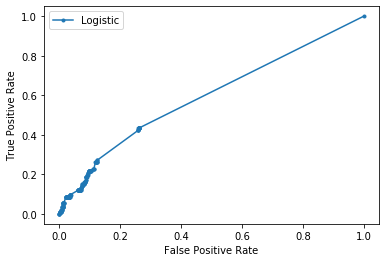

models_arr[0][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.         0.01114684 0.         0.02631579
 0.01114684 0.005      0.         0.        ]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0150000000
Accuracy: 98.71988828115909% | ROC AUC: 0.5984813807071291


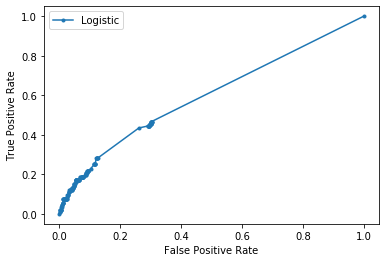

models_arr[0][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.02945467 0.0241589  0.0027039  0.0110783  0.00333863 0.03507104
 0.0110783  0.02551075 0.0253768  0.04931917]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, d

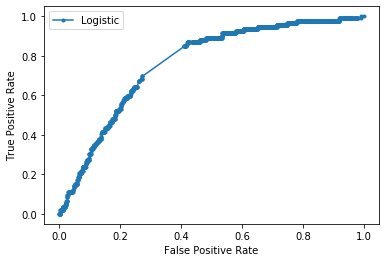

models_arr[0][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.         0.01112749 0.         0.02480692
 0.01112749 0.01       0.         0.00166667]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0150000000
Accuracy: 98.74316303968347% | ROC AUC: 0.6419340691376461


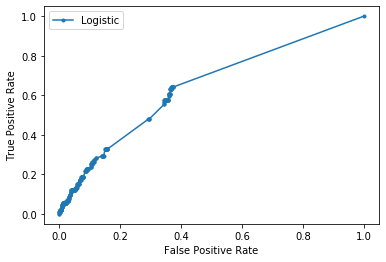

models_arr[0][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.02385546 0.01399539 0.00398988 0.01072261 0.0040453  0.02357601
 0.01072261 0.0170516  0.02873985 0.0119752 ]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0150000000
Accuracy: 98.9293611078785% | ROC AUC: 0.7214598794003774


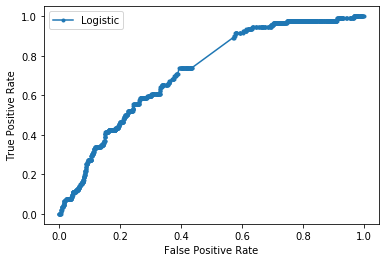

models_arr[0][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
25905    0
1224     0
21538    0
11270    0
4146     0
34314    0
32875    0
18688    0
25349    0
37967    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0150000000
Accuracy: 98.9293611078785% | ROC AUC: 0.5338425658362443


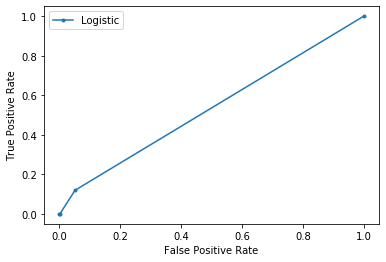

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 9
X_train dimension: (34369, 9) | y_train dimension: (34369,)
X_test dimension: (8593, 9) | y_test dimension: (8593,)

models_arr[1][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

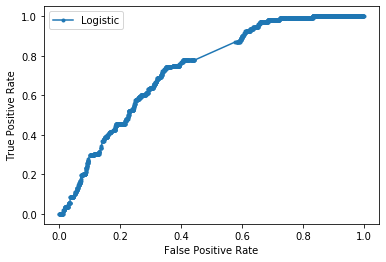

models_arr[1][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00126638 0.00017089 0.00610535 0.00449193 0.00483825 0.00181714
 0.0067736  0.00311209 0.00492923 0.00492923]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0155000000
Accuracy: 98.74316303968347% | ROC AUC: 0.7045281433466466


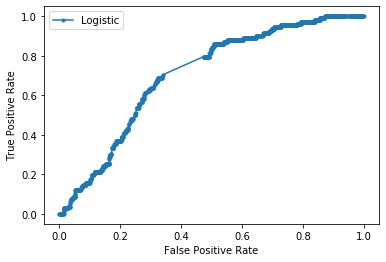

models_arr[1][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0155000000
Accuracy: 98.74316303968347% | ROC AUC: 0.49496387961326094


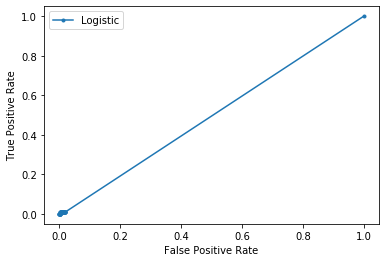

models_arr[1][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.47347266 0.46870559 0.47747548 0.47062762 0.48372677 0.46277175
 0.47721672 0.4698358  0.47781322 0.47781322]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0155000000
Accuracy: 98.74316303968347% | ROC AUC: 0.7961298806172112


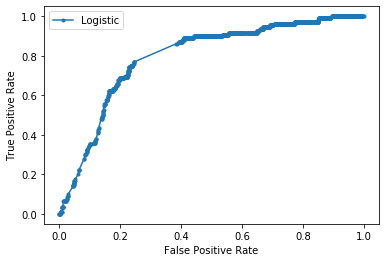

models_arr[1][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.1        0.         0.         0.
 0.         0.         0.01279534 0.01279534]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0155000000
Accuracy: 98.53369021296405% | ROC AUC: 0.6279551059604096


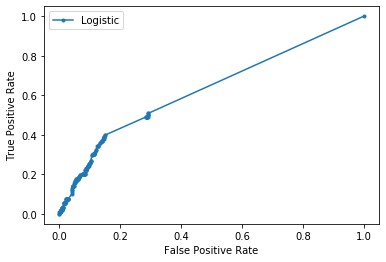

models_arr[1][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.04333333 0.         0.         0.
 0.005      0.         0.01198887 0.01198887]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0155000000
Accuracy: 98.60351448853719% | ROC AUC: 0.6330326938606254


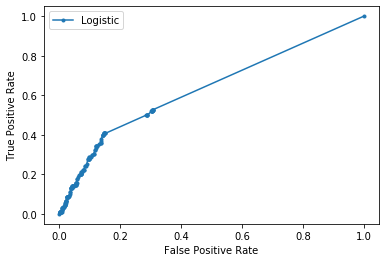

models_arr[1][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00395712 0.00227169 0.02253164 0.00298742 0.03578746 0.0008163
 0.00758232 0.00372459 0.01208787 0.01208787]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dt

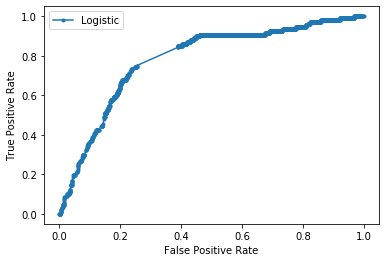

models_arr[1][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.018      0.         0.         0.
 0.00772727 0.         0.01180789 0.01180789]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0155000000
Accuracy: 98.62678924706157% | ROC AUC: 0.6616321831554598


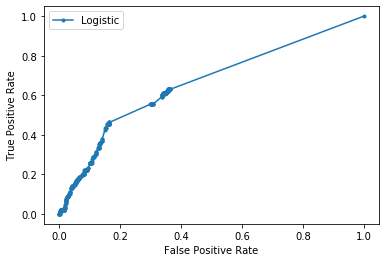

models_arr[1][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.0043456  0.00102232 0.01366366 0.00824084 0.02033121 0.00643006
 0.00769337 0.01152153 0.01149604 0.01149604]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0155000000
Accuracy: 98.74316303968347% | ROC AUC: 0.732666033741461


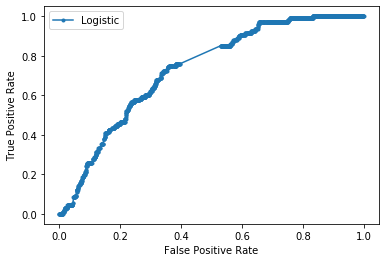

models_arr[1][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
16415    0
38600    0
29606    0
2801     0
31695    0
18192    0
33220    0
7510     0
1710     0
4735     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0155000000
Accuracy: 98.74316303968347% | ROC AUC: 0.5360128985791921


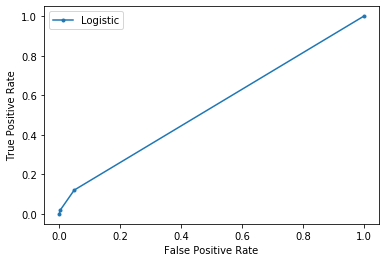

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 8
X_train dimension: (34369, 8) | y_train dimension: (34369,)
X_test dimension: (8593, 8) | y_test dimension: (8593,)

models_arr[2][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

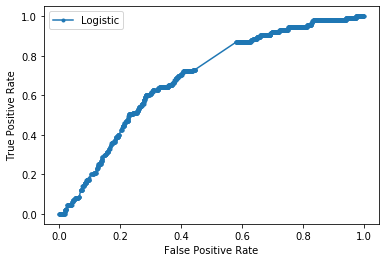

models_arr[2][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00487114 0.00109927 0.00221665 0.00176429 0.00117958 0.00115537
 0.01355137 0.01117566 0.00113976 0.01303497]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0158400000
Accuracy: 98.66170138484813% | ROC AUC: 0.6734673887401663


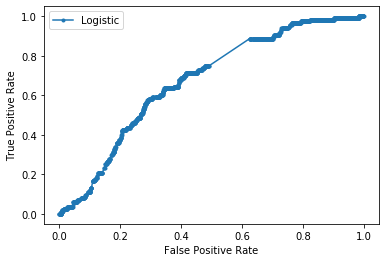

models_arr[2][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0158400000
Accuracy: 98.66170138484813% | ROC AUC: 0.50700175390012


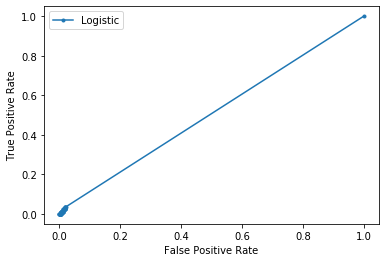

models_arr[2][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.4776577  0.46871359 0.47041053 0.47285924 0.47120721 0.47025561
 0.4800483  0.48275886 0.4759789  0.47134232]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0158400000
Accuracy: 98.66170138484813% | ROC AUC: 0.7209350031283014


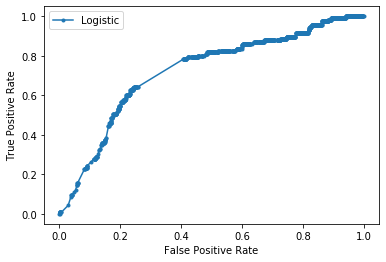

models_arr[2][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01045951 0.         0.00712501 0.         0.         0.
 0.         0.01634841 0.         0.        ]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0158400000
Accuracy: 98.47550331665309% | ROC AUC: 0.6419007764341467


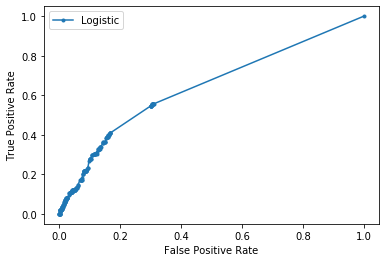

models_arr[2][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01065644 0.         0.01492537 0.         0.         0.
 0.         0.02702703 0.         0.        ]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0158400000
Accuracy: 98.4638659373909% | ROC AUC: 0.6542298737397048


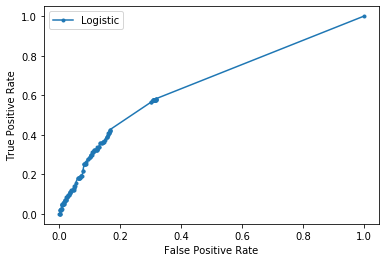

models_arr[2][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01109352 0.00139507 0.00235718 0.00427068 0.00243971 0.00165942
 0.0269062  0.03680719 0.00153659 0.00348958]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, d

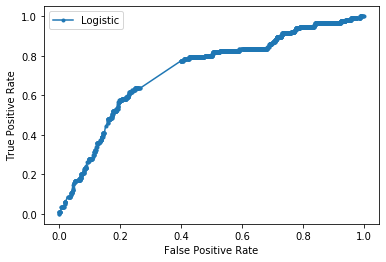

models_arr[2][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.0107766  0.         0.01510609 0.         0.         0.
 0.         0.02433668 0.         0.        ]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0158400000
Accuracy: 98.4638659373909% | ROC AUC: 0.6607003292408997


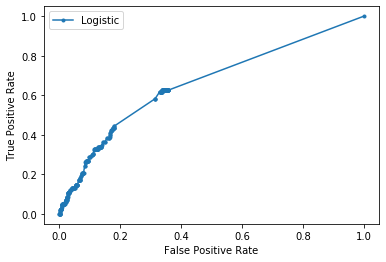

models_arr[2][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01112539 0.00281191 0.00485645 0.00491104 0.00300018 0.003123
 0.0206443  0.01539606 0.00886138 0.02495135]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0158400000
Accuracy: 98.66170138484813% | ROC AUC: 0.6913346051673385


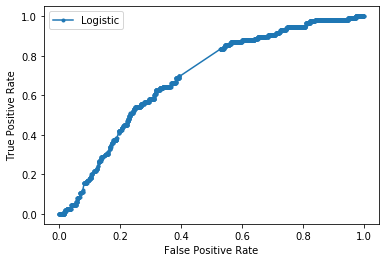

models_arr[2][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.  0.  0.  0.  0.  0.  0.  0.2 0.  0. ]
Correct labels:
17069    0
15714    0
31672    0
36621    0
16262    0
37407    0
23030    0
29095    0
15513    0
27325    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0158400000
Accuracy: 98.66170138484813% | ROC AUC: 0.5290167902602131


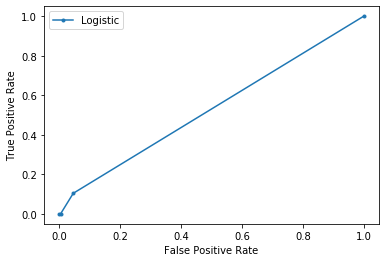

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 7
X_train dimension: (34369, 7) | y_train dimension: (34369,)
X_test dimension: (8593, 7) | y_test dimension: (8593,)

models_arr[3][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

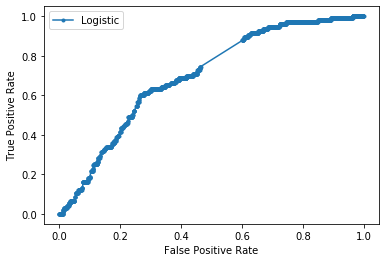

models_arr[3][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00868127 0.01028222 0.00774428 0.00755801 0.01034896 0.00755801
 0.00930345 0.00095228 0.00453175 0.00706257]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0160000000
Accuracy: 98.76643779820785% | ROC AUC: 0.6627766995471431


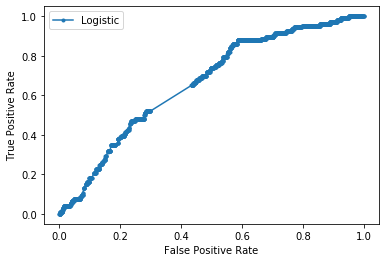

models_arr[3][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.00817761 0.         0.         0.
 0.         0.         0.         0.        ]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0160000000
Accuracy: 98.76643779820785% | ROC AUC: 0.5586768665061547


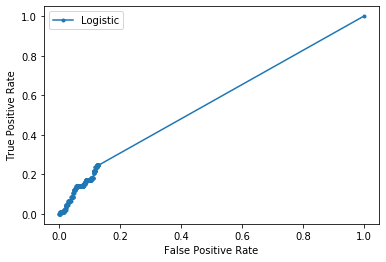

models_arr[3][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.4779566  0.46956826 0.48439722 0.477584   0.48415023 0.477584
 0.47757214 0.47051712 0.47553103 0.48083733]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0160000000
Accuracy: 98.76643779820785% | ROC AUC: 0.7460394476791363


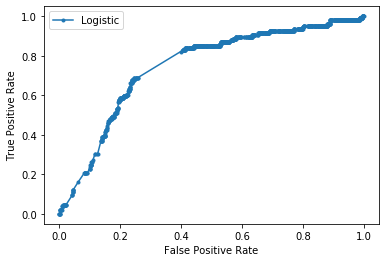

models_arr[3][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.03288983 0.         0.1        0.01065146 0.05023105 0.01065146
 0.02056489 0.         0.         0.05524074]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0160000000
Accuracy: 98.67333876411031% | ROC AUC: 0.6265714933605447


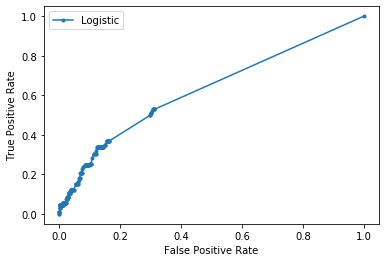

models_arr[3][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.02906977 0.         0.04777778 0.01111586 0.05147059 0.01111586
 0.01869159 0.         0.         0.04651163]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0160000000
Accuracy: 98.73152566042127% | ROC AUC: 0.6302674901236296


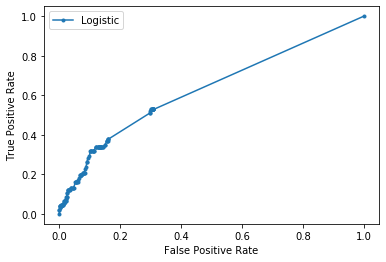

models_arr[3][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01558099 0.0026226  0.03959912 0.01118135 0.04174822 0.01118135
 0.01397264 0.0021549  0.00884499 0.02233415]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, d

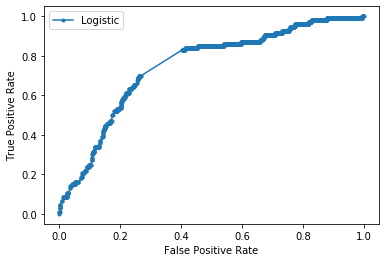

models_arr[3][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.03120969 0.         0.06425397 0.01151111 0.05461628 0.01151111
 0.01886437 0.         0.         0.04554035]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0160000000
Accuracy: 98.71988828115909% | ROC AUC: 0.6487852675901655


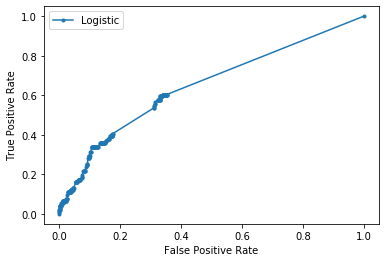

models_arr[3][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01336783 0.01358439 0.01989277 0.01128943 0.01697445 0.01128943
 0.01454435 0.00170925 0.0075598  0.02061111]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0160000000
Accuracy: 98.76643779820785% | ROC AUC: 0.6961396008545812


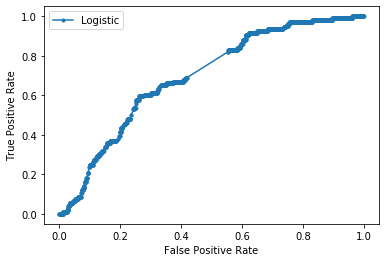

models_arr[3][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
20109    0
40061    0
35715    0
4340     0
19595    0
41604    0
6623     0
2456     0
30594    0
3650     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0160000000
Accuracy: 98.17293145583615% | ROC AUC: 0.5555238755833005


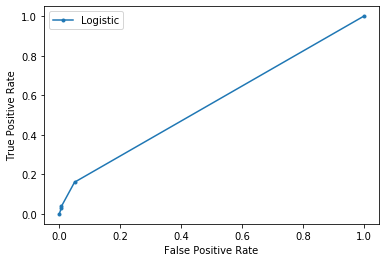

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 6
X_train dimension: (34369, 6) | y_train dimension: (34369,)
X_test dimension: (8593, 6) | y_test dimension: (8593,)

models_arr[4][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

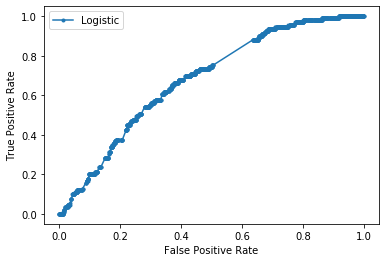

models_arr[4][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.11172074 0.03902825 0.10924352 0.02612148 0.02635239 0.03715381
 0.01088778 0.07976713 0.06502429 0.07976713]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0165000000
Accuracy: 98.73152566042127% | ROC AUC: 0.6757360860594579


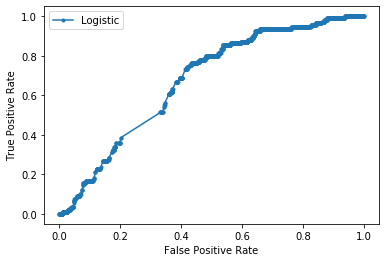

models_arr[4][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0165000000
Accuracy: 98.73152566042127% | ROC AUC: 0.4900125005947515


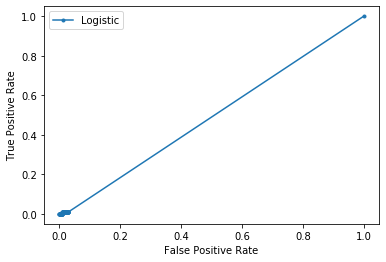

models_arr[4][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.48215859 0.483199   0.48237984 0.47194495 0.4685142  0.47597937
 0.47383141 0.47721594 0.47364328 0.47721594]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0165000000
Accuracy: 98.73152566042127% | ROC AUC: 0.7598263758223791


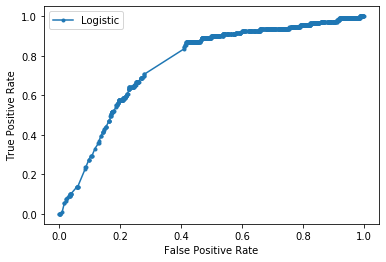

models_arr[4][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.07329902 0.         0.         0.         0.         0.
 0.         0.01091165 0.         0.01091165]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0165000000
Accuracy: 98.66170138484813% | ROC AUC: 0.6885805553032368


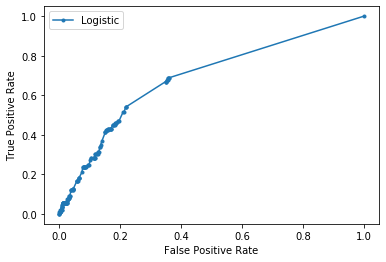

models_arr[4][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.04545455 0.         0.         0.         0.         0.
 0.         0.01097741 0.         0.01097741]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0165000000
Accuracy: 98.6966135226347% | ROC AUC: 0.6885989385308124


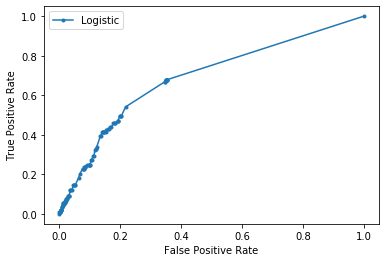

models_arr[4][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.02136425 0.01730498 0.03145834 0.00261912 0.00130282 0.00940896
 0.00247756 0.01060954 0.00530203 0.01060954]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, d

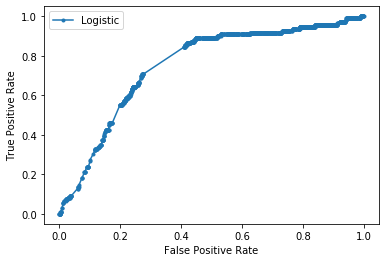

models_arr[4][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.04406925 0.         0.         0.         0.         0.
 0.         0.01121973 0.         0.01121973]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0165000000
Accuracy: 98.6966135226347% | ROC AUC: 0.6907384218107263


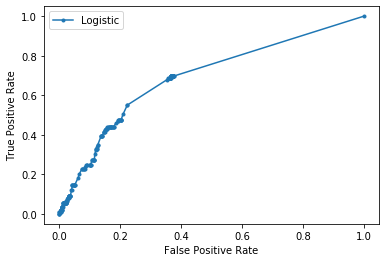

models_arr[4][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01928047 0.0100102  0.03081087 0.00514579 0.00568826 0.00746063
 0.00487805 0.01036044 0.01530856 0.01036044]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0165000000
Accuracy: 98.73152566042127% | ROC AUC: 0.6901031190930365


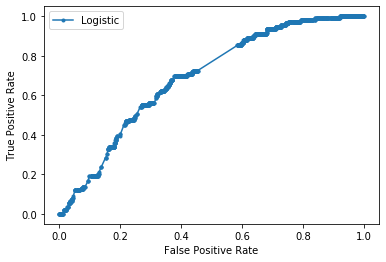

models_arr[4][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
22816    0
34793    0
27232    0
37502    0
3893     0
36166    0
36280    0
6851     0
41026    0
12975    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0165000000
Accuracy: 98.73152566042127% | ROC AUC: 0.5693031459109213


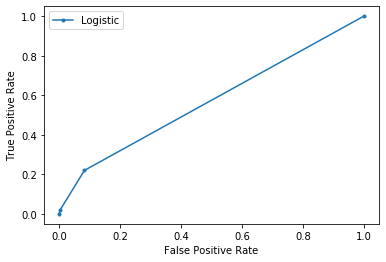

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 5
X_train dimension: (34369, 5) | y_train dimension: (34369,)
X_test dimension: (8593, 5) | y_test dimension: (8593,)

models_arr[5][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

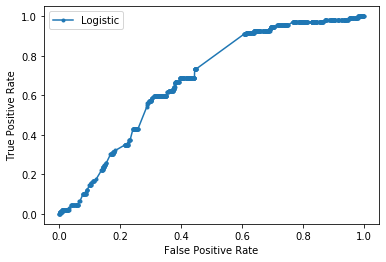

models_arr[5][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00699261 0.01986408 0.01034819 0.00530699 0.00324936 0.01986408
 0.01986408 0.01986408 0.00185239 0.03495079]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0170000000
Accuracy: 98.73152566042127% | ROC AUC: 0.6746422840187033


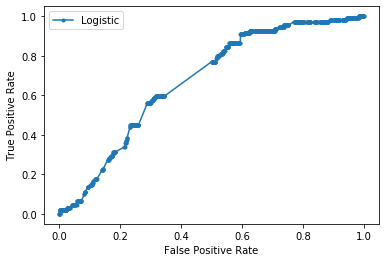

models_arr[5][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.         0.03982433 0.         0.
 0.         0.         0.         0.        ]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0170000000
Accuracy: 98.73152566042127% | ROC AUC: 0.4970202950832436


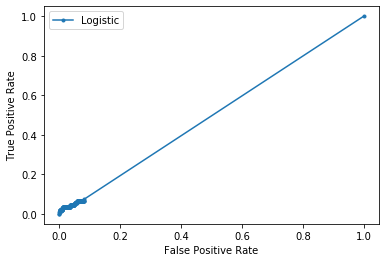

models_arr[5][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.46865716 0.47739869 0.46907067 0.46868841 0.47028327 0.47739869
 0.47739869 0.47739869 0.4720951  0.48259117]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0170000000
Accuracy: 98.73152566042127% | ROC AUC: 0.7538372284148468


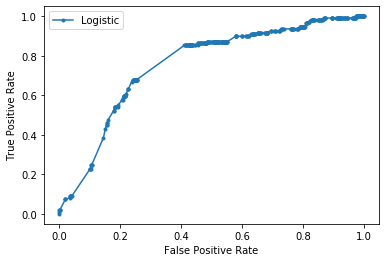

models_arr[5][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.01156559 0.         0.         0.         0.01156559
 0.01156559 0.01156559 0.03851207 0.03672946]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0170000000
Accuracy: 98.71988828115909% | ROC AUC: 0.686998516365398


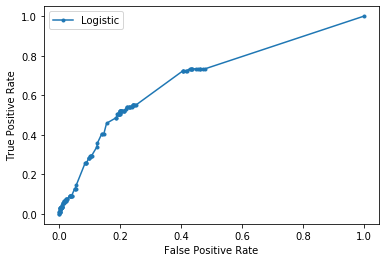

models_arr[5][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.0111026  0.         0.         0.         0.0111026
 0.0111026  0.0111026  0.0212766  0.03994083]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0170000000
Accuracy: 98.73152566042127% | ROC AUC: 0.6888390018556246


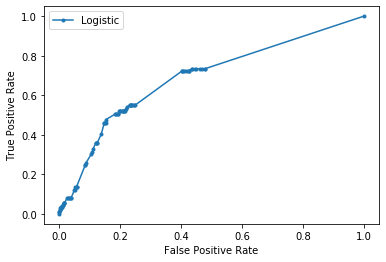

models_arr[5][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00223148 0.01102259 0.00146661 0.00126448 0.00184245 0.01102259
 0.01102259 0.01102259 0.00500101 0.03478171]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, d

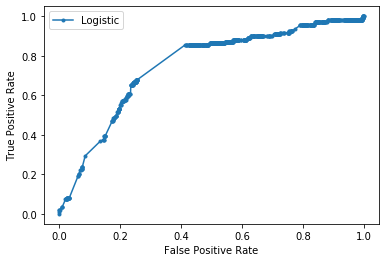

models_arr[5][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.01119613 0.         0.         0.         0.01119613
 0.01119613 0.01119613 0.02222744 0.0408647 ]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0170000000
Accuracy: 98.73152566042127% | ROC AUC: 0.6873942964414397


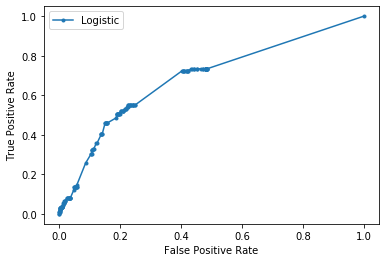

models_arr[5][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.0053206  0.01118818 0.00787901 0.00433321 0.00245538 0.01118818
 0.01118818 0.01118818 0.0015298  0.02172239]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0170000000
Accuracy: 98.73152566042127% | ROC AUC: 0.6787731033915974


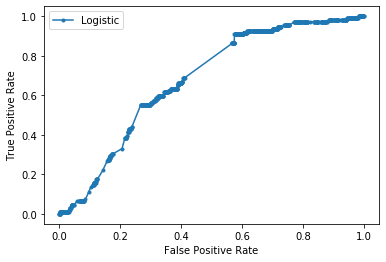

models_arr[5][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
10099    0
4944     0
35507    0
37975    0
30565    0
42328    1
3073     0
5322     0
24988    0
3863     0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0170000000
Accuracy: 98.73152566042127% | ROC AUC: 0.5205984064985791


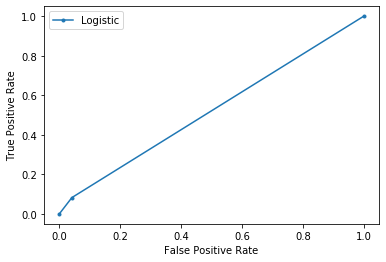

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 4
X_train dimension: (34369, 4) | y_train dimension: (34369,)
X_test dimension: (8593, 4) | y_test dimension: (8593,)

models_arr[6][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

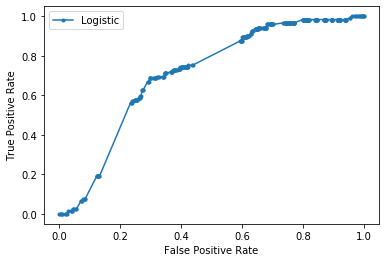

models_arr[6][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00296604 0.00292578 0.00598521 0.00250447 0.01996039 0.00292578
 0.0200961  0.01624456 0.00371078 0.01321115]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0200000000
Accuracy: 98.59187710927499% | ROC AUC: 0.628859578270472


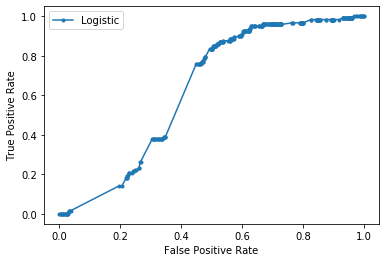

models_arr[6][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0200000000
Accuracy: 98.59187710927499% | ROC AUC: 0.501321319036359


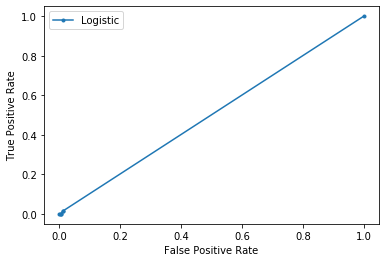

models_arr[6][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.47224556 0.46842721 0.46816637 0.47150005 0.48305115 0.46842721
 0.47236138 0.48305115 0.47280203 0.48382532]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0200000000
Accuracy: 98.59187710927499% | ROC AUC: 0.7888601440623073


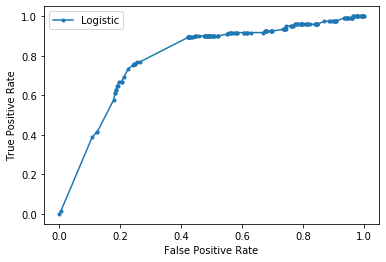

models_arr[6][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.00094583 0.         0.00476254 0.02481377 0.00094583
 0.00592462 0.03349962 0.         0.03581317]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0200000000
Accuracy: 98.59187710927499% | ROC AUC: 0.7436758129843374


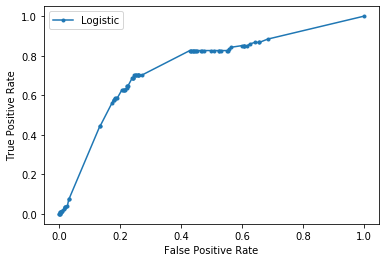

models_arr[6][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.00106383 0.         0.00431034 0.025      0.00106383
 0.00417537 0.03380917 0.         0.03621089]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0200000000
Accuracy: 98.59187710927499% | ROC AUC: 0.7423696142470286


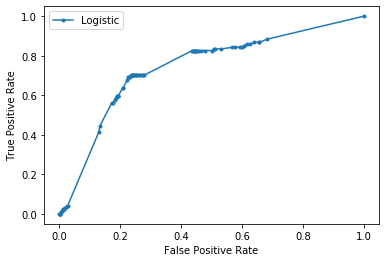

models_arr[6][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00201564 0.00182097 0.00107263 0.00323937 0.03295537 0.00182097
 0.00359481 0.03295537 0.00420205 0.03589937]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, d

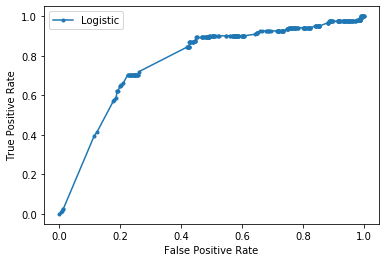

models_arr[6][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.00114794 0.         0.00460323 0.02497748 0.00114794
 0.00408137 0.03383292 0.         0.03613917]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0200000000
Accuracy: 98.59187710927499% | ROC AUC: 0.7439713904431907


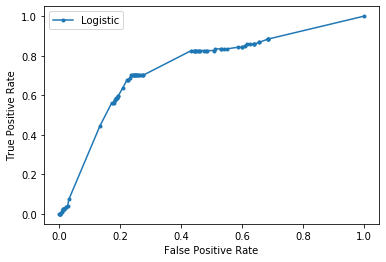

models_arr[6][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.0036143  0.00448472 0.00931393 0.00361231 0.02349538 0.00448472
 0.02594665 0.02122804 0.00766928 0.0191752 ]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0200000000
Accuracy: 98.59187710927499% | ROC AUC: 0.7098799936006993


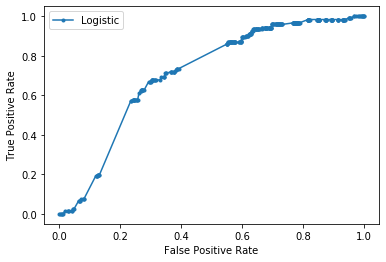

models_arr[6][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
13964    0
41441    0
33790    0
10706    0
21913    0
37497    0
23191    0
13178    0
6839     0
12256    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0200000000
Accuracy: 98.59187710927499% | ROC AUC: 0.49952980747469544


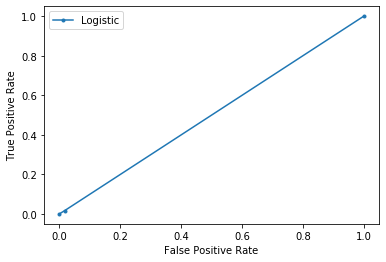

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 3
X_train dimension: (34369, 3) | y_train dimension: (34369,)
X_test dimension: (8593, 3) | y_test dimension: (8593,)

models_arr[7][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

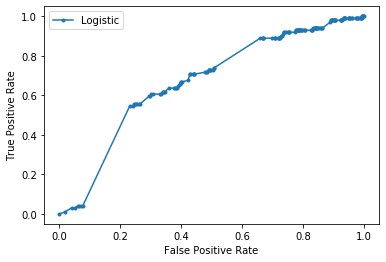

models_arr[7][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.02961498 0.02001698 0.01955882 0.02296066 0.02565145 0.01168476
 0.01749565 0.01749565 0.02296066 0.02961498]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0300000000
Accuracy: 98.84789945304317% | ROC AUC: 0.662252974767691


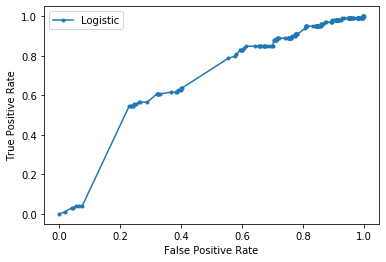

models_arr[7][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0300000000
Accuracy: 98.84789945304317% | ROC AUC: 0.48613162470002597


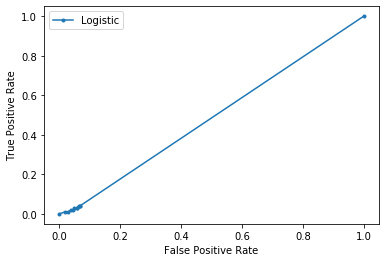

models_arr[7][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.47434134 0.48393875 0.46958741 0.47777765 0.47174178 0.4705351
 0.47562053 0.47562053 0.47777765 0.47434134]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0300000000
Accuracy: 98.84789945304317% | ROC AUC: 0.7453663072923729


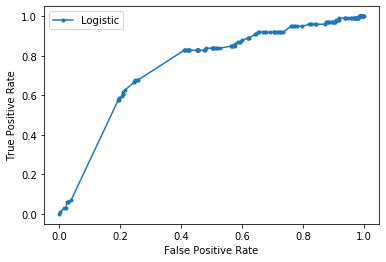

models_arr[7][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00800929 0.02996389 0.0031627  0.01146411 0.00576979 0.00233005
 0.00742346 0.00742346 0.01146411 0.00800929]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0300000000
Accuracy: 98.84789945304317% | ROC AUC: 0.7380307668157915


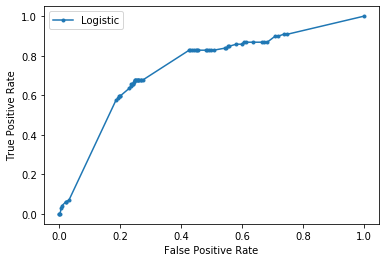

models_arr[7][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.0067659  0.02439024 0.00328947 0.01152369 0.00420875 0.00229358
 0.00732601 0.00732601 0.01152369 0.0067659 ]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0300000000
Accuracy: 98.84789945304317% | ROC AUC: 0.73359210185205


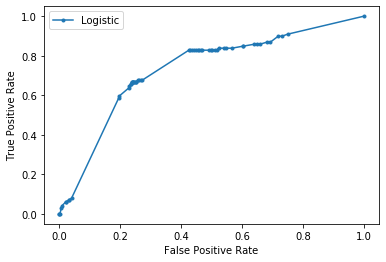

models_arr[7][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00565437 0.0312479  0.00282754 0.01153867 0.00348308 0.00282842
 0.00884577 0.00884577 0.01153867 0.00565437]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, d

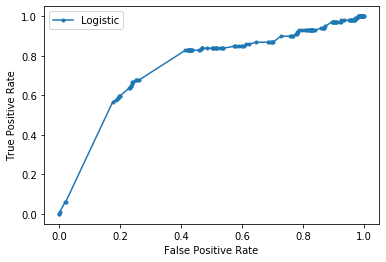

models_arr[7][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00687079 0.02631177 0.00337651 0.01177256 0.00413941 0.0023154
 0.00737392 0.00737392 0.01177256 0.00687079]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0300000000
Accuracy: 98.84789945304317% | ROC AUC: 0.735014971946924


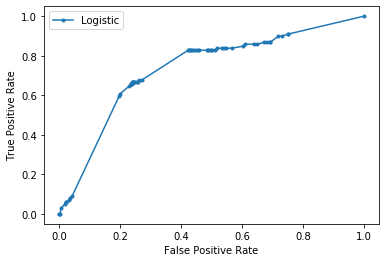

models_arr[7][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.01565316 0.01162505 0.00896676 0.00960492 0.01135237 0.00407518
 0.0075837  0.0075837  0.00960492 0.01565316]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0300000000
Accuracy: 98.84789945304317% | ROC AUC: 0.6611827005634399


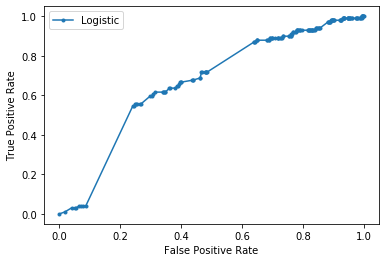

models_arr[7][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
5072     0
23091    0
24304    0
12954    0
5735     0
12397    0
5031     0
35667    0
12649    0
35681    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0300000000
Accuracy: 98.84789945304317% | ROC AUC: 0.49757226134669036


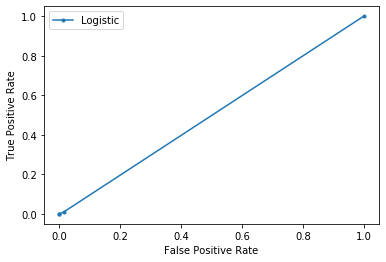

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 2
X_train dimension: (34369, 2) | y_train dimension: (34369,)
X_test dimension: (8593, 2) | y_test dimension: (8593,)

models_arr[8][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

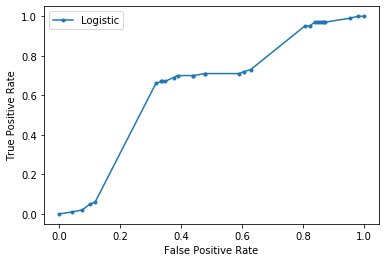

models_arr[8][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.03624117 0.01201279 0.0085926  0.00728352 0.01386611 0.0225362
 0.0225362  0.00728352 0.00854746 0.01024172]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0310000000
Accuracy: 98.83626207378099% | ROC AUC: 0.6265913104909926


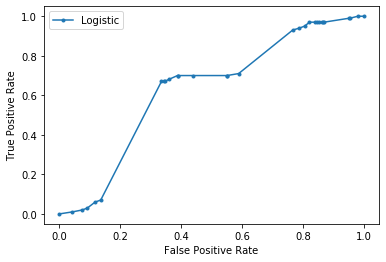

models_arr[8][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.04398847 0.         0.08734639 0.14962843 0.1590905  0.05844111
 0.05844111 0.14962843 0.17354314 0.        ]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0310000000
Accuracy: 98.83626207378099% | ROC AUC: 0.5286895090074178


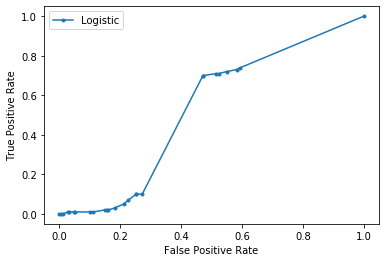

models_arr[8][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.47124594 0.47171485 0.4675965  0.47152071 0.47035168 0.48347325
 0.48347325 0.47152071 0.47205631 0.47723991]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0310000000
Accuracy: 98.83626207378099% | ROC AUC: 0.7463464029200517


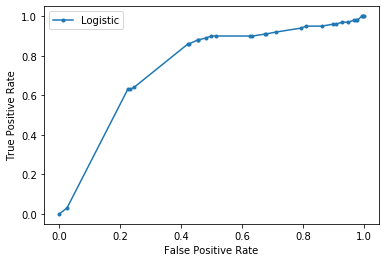

models_arr[8][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00413267 0.00411357 0.00103669 0.         0.00112379 0.03723335
 0.03723335 0.         0.00354187 0.01030593]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0310000000
Accuracy: 98.83626207378099% | ROC AUC: 0.748911456493583


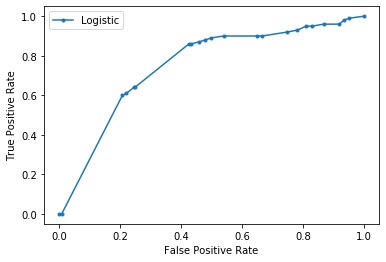

models_arr[8][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.0044586  0.00347873 0.00168634 0.         0.00174723 0.03623978
 0.03623978 0.         0.00344828 0.01040462]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0310000000
Accuracy: 98.83626207378099% | ROC AUC: 0.7532609207582714


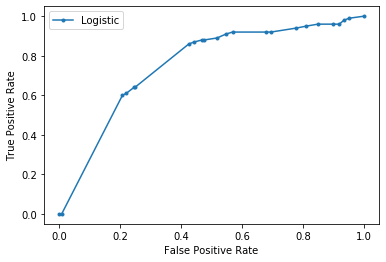

models_arr[8][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00424061 0.00346017 0.00163012 0.00264522 0.00217337 0.03624876
 0.03624876 0.00264522 0.00270391 0.01037262]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, d

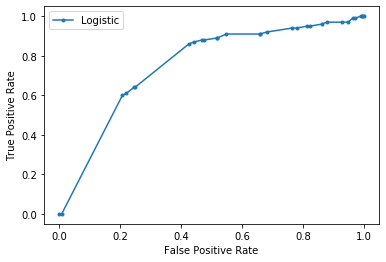

models_arr[8][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00456214 0.0035436  0.00152925 0.         0.00188451 0.03589804
 0.03589804 0.         0.00298547 0.01032353]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0310000000
Accuracy: 98.83626207378099% | ROC AUC: 0.7532609207582714


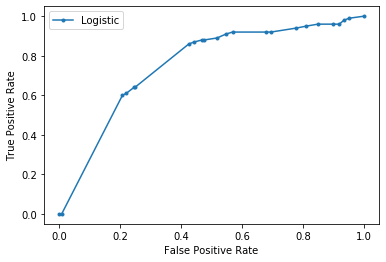

models_arr[8][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.02981405 0.00935778 0.00690261 0.0058972  0.01139218 0.01837927
 0.01837927 0.0058972  0.00697209 0.00791802]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0310000000
Accuracy: 98.83626207378099% | ROC AUC: 0.6314670905451549


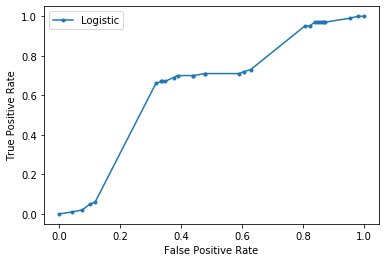

models_arr[8][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
360      0
10440    0
902      1
14650    0
14074    0
31095    0
41225    0
9942     0
11734    0
22835    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0310000000
Accuracy: 98.83626207378099% | ROC AUC: 0.4965224302366655


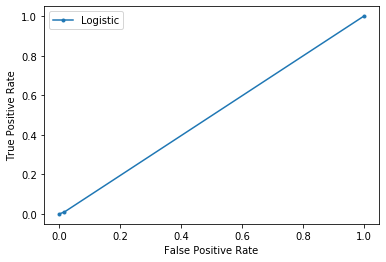

----------------------------------------------------------------------------------------------------------------------------- 

All NaN values are now converted to 0.
Number of relevant features: 1
X_train dimension: (34369, 1) | y_train dimension: (34369,)
X_test dimension: (8593, 1) | y_test dimension: (8593,)

models_arr[9][0]: CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabili

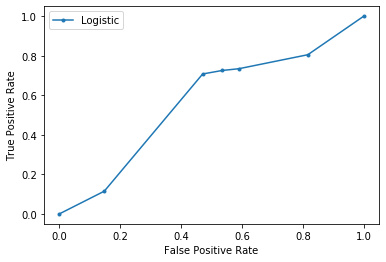

models_arr[9][1]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00302986 0.01341865 0.01341865 0.00302986 0.00236179 0.01716054
 0.01341865 0.00302986 0.01048398 0.00236179]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0350000000
Accuracy: 98.68497614337251% | ROC AUC: 0.5674919644347971


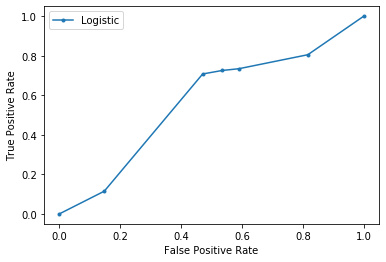

models_arr[9][2]: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.         0.         0.         0.         0.         0.01000083
 0.         0.         0.         0.        ]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0350000000
Accuracy: 98.68497614337251% | ROC AUC: 0.48358344464852226


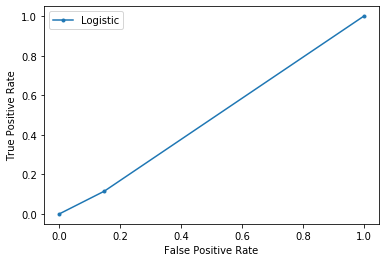

models_arr[9][3]: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.47027835 0.48146449 0.48146449 0.47027835 0.47726584 0.47438355
 0.48146449 0.47027835 0.47523389 0.47726584]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0350000000
Accuracy: 98.68497614337251% | ROC AUC: 0.6649195399899817


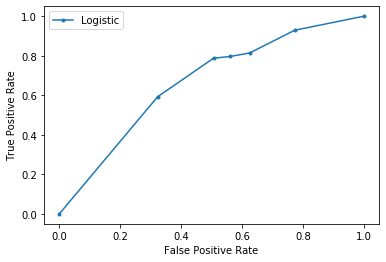

models_arr[9][4]: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00248841 0.02459941 0.02459941 0.00248841 0.01038717 0.00579086
 0.02459941 0.00248841 0.00636516 0.01038717]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0350000000
Accuracy: 98.68497614337251% | ROC AUC: 0.6649195399899817


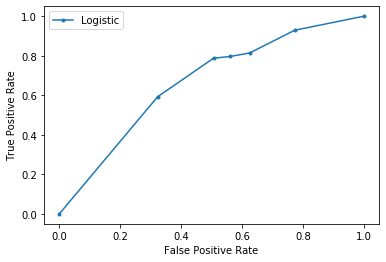

models_arr[9][5]: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00258298 0.02393594 0.02393594 0.00258298 0.01048951 0.00588351
 0.02393594 0.00258298 0.00680272 0.01048951]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0350000000
Accuracy: 98.68497614337251% | ROC AUC: 0.6649195399899817


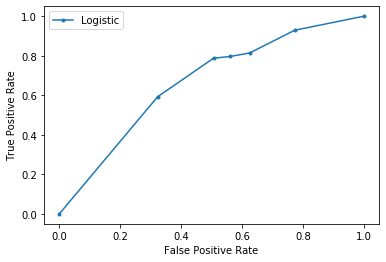

models_arr[9][6]: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00258666 0.02393369 0.02393369 0.00258666 0.01048752 0.00588595
 0.02393369 0.00258666 0.00680896 0.01048752]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, d

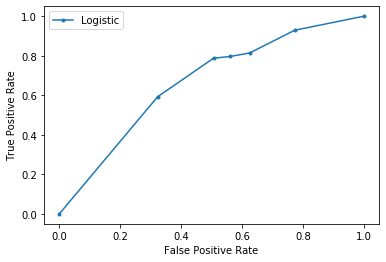

models_arr[9][7]: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00261349 0.02391018 0.02391018 0.00261349 0.01047512 0.00579229
 0.02391018 0.00261349 0.00628792 0.01047512]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0350000000
Accuracy: 98.68497614337251% | ROC AUC: 0.6649195399899817


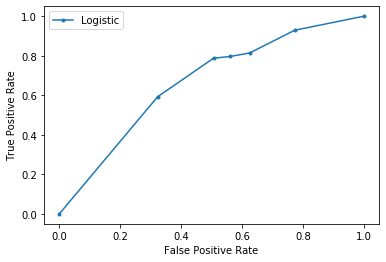

models_arr[9][8]: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0.00714193 0.01581333 0.01581333 0.00714193 0.00625223 0.01803888
 0.01581333 0.00714193 0.01385847 0.00625223]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0350000000
Accuracy: 98.68497614337251% | ROC AUC: 0.5674919644347971


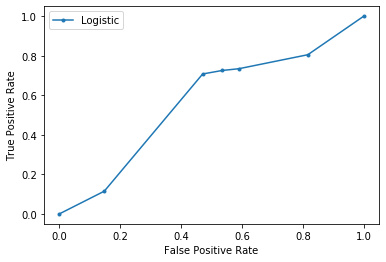

models_arr[9][9]: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Predictions:
[0 0 0 0 0 0 0 0 0 0]
Probabilities:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Correct labels:
2477     0
7410     0
6224     0
4437     0
3488     0
9503     0
8596     0
39306    0
16761    0
40283    0
Name: RESPONSE, dtype: int64
Minimum correlation target: 0.0350000000
Accuracy: 98.68497614337251% | ROC AUC: 0.5


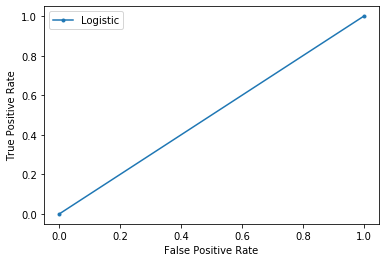

----------------------------------------------------------------------------------------------------------------------------- 



In [146]:
# represents the proportion of the dataset to include in the test split
test_size = 0.2

# # number of data items to train
# n_items = 20000

# list of classifiers
clfs = [
#     sklearn.svm.SVC(gamma='scale', probability=True),
#     sklearn.svm.SVC(kernel='poly', gamma='scale', probability=True),
    
    # wrap with CalibratedClassifierCV to support .predict_proba()
    CalibratedClassifierCV(sklearn.svm.LinearSVC(dual=False), cv=5),
    
    # .predict_proba() is only available for log loss and modified Huber loss
    sklearn.linear_model.SGDClassifier(loss='log'),
    sklearn.linear_model.SGDClassifier(loss='modified_huber'),
    
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(n_estimators=100),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_estimators=100),
    
    sklearn.linear_model.LogisticRegression(solver='lbfgs', max_iter=7600),
    sklearn.neighbors.KNeighborsClassifier()
]

# minimum correlation targets
min_cor_targets = [
    # custom
#     0.0010, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.0040, 0.0045,
#     0.005, 0.006, 0.007, 0.008, 0.009,
#     0.010, 0.011, 0.012, 0.013, 0.0136,
    0.015, 0.0155, 0.01584, 0.016, 0.0165, 0.017, 0.020,
    0.030, 0.031, 0.035,
    
#     # correlation target description values
#     0.005359, 0.004708, 0.000055, 0.002178, 0.004217, 0.007067, 0.040392,
]

models_arr = []
print('test_size: {}\n'.format(test_size))

for i, min_cor_target in enumerate(min_cor_targets):
    models_arr.append([])
    
    # selecting highly correlated features
    relevant_features = cor_target[cor_target >= min_cor_target]
    
    # new instance of our features and class labels
#     X = clear_features(mailout_train[relevant_features.index][:n_items])
#     y = mailout_train['RESPONSE'][:n_items]
    X = clear_features(mailout_train[relevant_features.index])
    y = mailout_train['RESPONSE']
    
    print('Number of relevant features:', X.shape[1])
    
#     # uncomment to use the Nystroem method
#     print('Using the Nystroem method to speed up kernel machines...')
#     feature_map_nystroem = Nystroem(n_components=X.shape[1])
#     X = feature_map_nystroem.fit_transform(X)
#     print(X, '\n')
    
    # split training and test features and class labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    print('X_train dimension: {} | y_train dimension: {}'.format(X_train.shape, y_train.shape))
    print('X_test dimension: {} | y_test dimension: {}\n'.format(X_test.shape, y_test.shape))
    
    for j, clf in enumerate(clfs):
        model = clone(clf)
        
        # start training
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)
        probs = probs[:, 1]
        
        models_arr[i].append(model)
        print('models_arr[{}][{}]: {}'.format(i, j, model))
        
        accuracy = accuracy_score(y_test, preds) * 100
        roc_auc = roc_auc_score(y_test, probs)
        
        print('Predictions:\n{}'.format(preds[:10]))
        print('Probabilities:\n{}'.format(probs[:10]))
        print('Correct labels:\n{}'.format(y_test[:10]))
        print('Minimum correlation target: {:.10f}'.format(min_cor_target))
        print('Accuracy: {}% | ROC AUC: {}'.format(accuracy, roc_auc))
        
        # calculate roc curve
        fpr, tpr, _ = roc_curve(y_test, probs)
        # plot the roc curve for the model
        plt.plot(fpr, tpr, marker='.', label='Logistic')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()
    
    print('-' * 125, '\n')

The high performing model above have this record:

> Variable: `models_arr[1][3]`  
> Minimum correlation target: 0.0155000000  
> Accuracy: 98.74316303968347% | ROC AUC: 0.7961298806172112

Some articles said that the AUC score of 0.5 means the model is performing poorly and its probability predictions are almost random. It seems that our chance of getting around 0.5 of ROC AUC is high since our training, test and target features contain a lot of `NaN` and zeros. We tried to use Pearson correlation to get our target relevant features to increase our ROC AUC score.

> Tips: You can use CTRL+F and type "ROC AUC: 0.7", etc... to easily find the high performing models on the result above.

We assign the best performing classifier to `model`, repeatedly train it with full datasets and save as .joblib.pkl file in our folder. Later, we will use it to predict the probabilities of our submission's RESPONSE for "Udacity+Arvato: Identify Customer Segments" competition through Kaggle.

In [11]:
from sklearn.externals import joblib
filename = data_dir + '/model.joblib.pkl'

# uncomment to load the model
model = joblib.load(filename)

# # store to model
# model = models_arr[1][3]

# store the minimum correlation target
min_cor_target = 0.0155000000

# selecting highly correlated features
relevant_features = cor_target[cor_target >= min_cor_target]

# new instance of our features and class labels
X = clear_features(mailout_train[relevant_features.index])
y = mailout_train['RESPONSE']

print('Minimum correlation target: {:.10f}'.format(min_cor_target))
print('Number of relevant features:', X.shape[1])
print('Relevant features:', relevant_features.index)

# # we stop using the Nystroem method
# print('Using the Nystroem method to speed up kernel machines...')
# feature_map_nystroem = Nystroem(n_components=X.shape[1])
# X = feature_map_nystroem.fit_transform(X)
# print(X, '\n')

def infinity():
    while True:
        yield

All NaN values are now converted to 0.
Minimum correlation target: 0.0155000000
Number of relevant features: 9
Relevant features: Index(['D19_BANKEN_DIREKT', 'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX',
       'D19_SOZIALES', 'FINANZ_VORSORGER', 'KBA05_CCM4', 'KBA05_KW3',
       'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN'],
      dtype='object')


In [20]:
filename = data_dir + '/model2.joblib.pkl'

test_size = 0.3
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

# deduction for the current score to save the model
deduction = 0.04

# number of passes through the entire training dataset
epochs = infinity() # or range(5000)

print('epochs:', epochs)
print('deduction:', deduction)
print('test_size:', test_size)
print('model: {}'.format(model))
print('# accuracy_current = {}\n# roc_auc_current = {}\n'.format(accuracy_current, roc_auc_current))

for i in epochs:
#     print('Epoch:', i + 1)

    # split training and test features and class labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # start training with full dataset
    model2 = clone(model)
    model2.fit(X, y)

    preds = model2.predict(X_test)
    probs = model2.predict_proba(X_test)
    probs = probs[:, 1]

    accuracy_new = accuracy_score(y_test, preds)
    roc_auc_new = roc_auc_score(y_test, probs)
    
    if (roc_auc_new > roc_auc_current - deduction and accuracy_new > accuracy_current - deduction):
        model = model2
        _ = joblib.dump(model, filename, compress=9)
        
        print('Predictions:\n{}'.format(preds[:3]))
        print('Probabilities:\n{}'.format(probs[:3]))
        print('Correct labels:\n{}'.format(y_test[:3]))
        
        print('New accuracy: {} | New ROC AUC: {}'.format(accuracy_new, roc_auc_new))
        
        if (roc_auc_new > roc_auc_current):
            roc_auc_current = roc_auc_new
            print('roc_auc_current updated!')
        if (accuracy_new > accuracy_current):
            accuracy_current = accuracy_new
            print('accuracy_current updated!')
        
        print('# accuracy_current = {}\n# roc_auc_current = {}\n'.format(accuracy_current, roc_auc_current))

epochs: <generator object infinity at 0x000001488958AB48>
deduction: 0.04
test_size: 0.3
model: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47825659 0.47749122]
Correct labels:
9406     0
21545    0
13005    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8022838931475205
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46958882 0.47139289]
Correct labels:
40388    0
38280    0
20711    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.804412220465721
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47700801 0.46874294 0.46710614]
Correct labels:
32524    0


Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47220025 0.46403841]
Correct labels:
39086    0
9795     0
18493    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9880518271394212 | New ROC AUC: 0.8086355732998843
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47027398 0.48571274 0.4832393 ]
Correct labels:
6196     0
30678    0
17129    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8077099220832035
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47268123 0.48279153 0.47220025]
Correct labels:
36585    0
32386    0
40560    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8088291382634623
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48265428 0.46807221 0.47418564]
Correct labels:
19864    0
28674    0
324

Predictions:
[0 0 0]
Probabilities:
[0.46619791 0.47749122 0.47194117]
Correct labels:
1638     0
37713    0
41392    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.805190382288779
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47183483 0.46674878 0.46925249]
Correct labels:
9943     0
3062     0
42377    0
Name: RESPONSE, dtype: int64
New accuracy: 0.988362169291644 | New ROC AUC: 0.8026278881126201
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47256267 0.48129102 0.47749122]
Correct labels:
21821    0
40362    0
3167     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8047886128900438
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47164634 0.48448735 0.47749122]
Correct labels:
18267    0
5835     0
25476

Predictions:
[0 0 0]
Probabilities:
[0.46891174 0.47193847 0.4832393 ]
Correct labels:
17941    0
14747    0
39656    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8071276710660696
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47267793 0.47167582 0.47152625]
Correct labels:
1620     0
1825     0
31498    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8127041430290528
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46827968 0.47749122 0.4752163 ]
Correct labels:
30396    0
24928    0
38523    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8017550298336444
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46903202 0.48416193 0.4713441 ]
Correct labels:
40702    0
12002    0
3338

Predictions:
[0 0 0]
Probabilities:
[0.48113943 0.48398132 0.48340966]
Correct labels:
11997    0
11424    0
9635     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878190705252541 | New ROC AUC: 0.8130586755674553
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48204962 0.48417027 0.48185816]
Correct labels:
16798    0
19143    1
8402     0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8091024923403252
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47462085 0.47746094 0.45940735]
Correct labels:
27029    0
36448    0
4936     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8007801613817713
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46976312 0.46591095 0.47809383]
Correct labels:
11250    0
21932    0
1167

Predictions:
[0 0 0]
Probabilities:
[0.46545584 0.48398132 0.46922791]
Correct labels:
23926    0
7455     0
33831    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878190705252541 | New ROC AUC: 0.8107534353482173
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47733814 0.47173198 0.47445923]
Correct labels:
33169    0
14696    0
41726    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.8032734835463665
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48384487 0.48433249 0.48340966]
Correct labels:
4320     0
18093    0
40223    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8262597061889276
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48448735 0.4795084  0.48235631]
Correct labels:
23616    0
42882    0
389

Predictions:
[0 0 0]
Probabilities:
[0.47087716 0.48349066 0.47350103]
Correct labels:
7819     0
26342    1
5109     0
Name: RESPONSE, dtype: int64
New accuracy: 0.988362169291644 | New ROC AUC: 0.8061967187377346
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47749122 0.47749122]
Correct labels:
20316    0
39246    0
8153     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.8098855645672125
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47368049 0.47060379]
Correct labels:
30466    0
30920    0
35323    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8083717801145657
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46957701 0.47974477 0.47416577]
Correct labels:
442     0
2500    0
6820  

Predictions:
[0 0 0]
Probabilities:
[0.48171611 0.47394594 0.47749122]
Correct labels:
37608    0
14116    0
8685     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9863449453021956 | New ROC AUC: 0.8122821217365188
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46845874 0.47749122 0.47132655]
Correct labels:
6675     0
5885     0
24166    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8038926686859253
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48341989 0.4678578  0.48417027]
Correct labels:
33748    0
24609    0
42386    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8086380997227017
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48304053 0.47749122 0.467827  ]
Correct labels:
32324    0
42421    0
345

Predictions:
[0 0 0]
Probabilities:
[0.4710046  0.48336118 0.47700801]
Correct labels:
36493    0
28548    0
13860    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9876638994491427 | New ROC AUC: 0.8069681384537096
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47243196 0.47235318 0.47749122]
Correct labels:
27823    0
22069    0
36946    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878190705252541 | New ROC AUC: 0.813655746791774
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47317013 0.47749122]
Correct labels:
15121    0
22170    0
1409     0
Name: RESPONSE, dtype: int64
New accuracy: 0.988362169291644 | New ROC AUC: 0.8055559044404323
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.4643078  0.48454099]
Correct labels:
39173    0
33090    0
33791

Predictions:
[0 0 0]
Probabilities:
[0.48031704 0.47733814 0.47749122]
Correct labels:
20929    0
33169    0
40889    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9872759717588642 | New ROC AUC: 0.8022806555177537
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47702141 0.47460996 0.46827549]
Correct labels:
29455    0
32834    0
6027     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8050444366799271
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47781631 0.46957701 0.48449693]
Correct labels:
34963    0
25591    0
14140    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9862673597641399 | New ROC AUC: 0.8191283737417913
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47286418 0.47332185 0.47749122]
Correct labels:
7080     0
11296    0
118

Predictions:
[0 0 0]
Probabilities:
[0.46997084 0.48422392 0.47301203]
Correct labels:
1015     0
34433    0
7938     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878190705252541 | New ROC AUC: 0.8076700264742431
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47050829 0.4710019  0.47749122]
Correct labels:
11727    0
40836    0
25845    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9877414849871984 | New ROC AUC: 0.802259062648832
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46977448 0.47139763 0.47749122]
Correct labels:
6441     0
20583    0
41812    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8053896920175989
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47342632 0.47071209 0.47749122]
Correct labels:
15740    0
18937    0
3348

Predictions:
[0 0 0]
Probabilities:
[0.48417027 0.47416577 0.47211689]
Correct labels:
12425    0
35942    0
9622     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.8177356005071361
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47266287 0.48333888 0.46977448]
Correct labels:
36753    0
37005    0
6441     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9894483668244239 | New ROC AUC: 0.8028699129616561
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46755018 0.47749122 0.47749122]
Correct labels:
11718    0
3508     0
6891     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871208006827528 | New ROC AUC: 0.8034936255278128
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47721827 0.48417027 0.47749122]
Correct labels:
10743    0
19741    0
161

Predictions:
[0 0 0]
Probabilities:
[0.47077343 0.47749122 0.48012819]
Correct labels:
24945    0
35301    0
27904    0
Name: RESPONSE, dtype: int64
New accuracy: 0.986500116378307 | New ROC AUC: 0.8029702903168943
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48388828 0.47215467 0.46581804]
Correct labels:
27684    0
34076    0
9762     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8185670386055213
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48352845 0.47139289 0.47749122]
Correct labels:
3259     1
23752    0
34821    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.8121884357839413
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48366427 0.47749122 0.4841429 ]
Correct labels:
22926    0
3985     0
1595

Predictions:
[0 0 0]
Probabilities:
[0.47275672 0.47120485 0.4724942 ]
Correct labels:
26773    0
13080    0
8352     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9880518271394212 | New ROC AUC: 0.8069779062711926
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46984315 0.46977448 0.48064228]
Correct labels:
1317     0
20418    0
41982    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9861897742260842 | New ROC AUC: 0.8019392210056052
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4841858  0.46512094 0.46872334]
Correct labels:
25647    0
9161     0
38580    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8055780816766733
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48449693 0.47399509 0.46989108]
Correct labels:
36945    0
34994    0
224

Predictions:
[0 0 0]
Probabilities:
[0.4760662  0.47781631 0.48103538]
Correct labels:
18586    0
42392    0
8914     0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.803796940058135
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4861931  0.46829764 0.47661928]
Correct labels:
39825    0
26612    0
16476    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8174759779912593
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47266287 0.48210498 0.47263498]
Correct labels:
23698    0
8576     0
26086    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9889828535960897 | New ROC AUC: 0.8068283396148446
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47135724 0.4861931  0.48505338]
Correct labels:
3312    0
2338    0
5797   

Predictions:
[0 0 0]
Probabilities:
[0.48391565 0.47749122 0.47417222]
Correct labels:
26854    0
19334    0
28303    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871208006827528 | New ROC AUC: 0.8018617739053361
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46797757 0.48416193 0.47749122]
Correct labels:
29083    0
18647    0
32416    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8108272065116485
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47200176 0.48416193 0.46926081]
Correct labels:
17590    0
30884    0
6828     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9898362945147025 | New ROC AUC: 0.8035778179594543
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47082172 0.47131823 0.48172431]
Correct labels:
4216     0
22230    0
193

Predictions:
[0 0 0]
Probabilities:
[0.47042184 0.47749122 0.47410477]
Correct labels:
28245    0
39217    0
40592    0
Name: RESPONSE, dtype: int64
New accuracy: 0.986500116378307 | New ROC AUC: 0.8075820033357289
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48416193 0.46787961 0.48568698]
Correct labels:
31842    0
4709     0
30118    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.8040057421952953
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47454053 0.47211689 0.47749122]
Correct labels:
34179    0
3846     0
1380     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.8134621258885445
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47074645 0.46896561 0.47749122]
Correct labels:
35435    0
7224     0
1212

Predictions:
[0 0 0]
Probabilities:
[0.47092009 0.47220025 0.47749122]
Correct labels:
10081    0
35896    0
29203    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9892931957483125 | New ROC AUC: 0.801352323602923
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46797323 0.48096877 0.47057174]
Correct labels:
38079    0
7518     0
39219    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9869656296066414 | New ROC AUC: 0.8043130781123078
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47911766 0.47185095 0.47928622]
Correct labels:
7924     0
12255    0
3720     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.8102884524305469
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47651597 0.46669965]
Correct labels:
13100    0
7246     0
8721

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.48341989 0.47029332]
Correct labels:
31584    0
42547    0
32956    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8101118919431479
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47166749 0.47749122]
Correct labels:
5330     0
27841    0
16036    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.810553348856321
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47135114 0.47180975 0.47982526]
Correct labels:
11929    0
3435     0
33410    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9866552874544186 | New ROC AUC: 0.8137443286865593
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.4681898  0.46994956]
Correct labels:
39800    0
36733    0
1460

Predictions:
[0 0 0]
Probabilities:
[0.46933617 0.46941363 0.47120658]
Correct labels:
17343    0
18609    0
25532    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9876638994491427 | New ROC AUC: 0.8236943386345335
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4723648  0.46479788 0.47139289]
Correct labels:
32309    0
35290    0
14063    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8035047808023572
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48449693 0.47182872 0.47911766]
Correct labels:
35588    0
16567    0
7924     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8106048775917329
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47107655 0.47325649 0.47130005]
Correct labels:
27330    0
32848    0
229

Predictions:
[0 0 0]
Probabilities:
[0.4710895  0.47238648 0.48443209]
Correct labels:
30127    0
19586    0
28559    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9887500969819226 | New ROC AUC: 0.8024068121306578
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47166749 0.47164291 0.47120991]
Correct labels:
1916     0
10133    0
39263    0
Name: RESPONSE, dtype: int64
New accuracy: 0.988362169291644 | New ROC AUC: 0.8020590313211399
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47199642 0.46947203 0.46890965]
Correct labels:
15877    0
12566    0
31902    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.801805464262239
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48374651 0.47749122 0.47014182]
Correct labels:
23555    0
32877    0
42361

Predictions:
[0 0 0]
Probabilities:
[0.47071901 0.48422392 0.4713111 ]
Correct labels:
17536    0
29029    0
28765    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8079406133005631
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48333888 0.46722333 0.47749122]
Correct labels:
22822    0
7989     0
2693     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9872759717588642 | New ROC AUC: 0.8109641094446307
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47749122 0.473591  ]
Correct labels:
12896    0
25376    0
4557     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.8077040384644614
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47059546 0.48308429]
Correct labels:
9205    0
7410    0
3050 

Predictions:
[0 0 0]
Probabilities:
[0.4741187  0.47154578 0.48061057]
Correct labels:
4203     0
34511    0
28200    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8014982323175699
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47135466 0.4715436  0.47749122]
Correct labels:
1694    0
6893    0
9237    0
Name: RESPONSE, dtype: int64
New accuracy: 0.98681045853053 | New ROC AUC: 0.8063076083487881
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47212052 0.46471061 0.46979672]
Correct labels:
19357    0
9352     0
15686    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9868880440685857 | New ROC AUC: 0.8023926817014626
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46472453 0.47164291 0.47164634]
Correct labels:
12892    0
17168    0
41439   

Predictions:
[0 0 0]
Probabilities:
[0.48406233 0.47180414 0.47076338]
Correct labels:
14922    0
40034    0
30040    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9872759717588642 | New ROC AUC: 0.8024958071781111
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48416193 0.47622399 0.47781631]
Correct labels:
3128     1
28636    0
8779     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9887500969819226 | New ROC AUC: 0.8011150615840855
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48396929 0.47418564 0.46603752]
Correct labels:
13635    0
23002    0
4433     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.811114416747805
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47153458 0.48371791 0.4846406 ]
Correct labels:
12526    0
37955    0
317 

Predictions:
[0 0 0]
Probabilities:
[0.47155916 0.47219883 0.47749122]
Correct labels:
15048    0
18657    0
17655    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.801185245606068
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.48482846 0.47187553]
Correct labels:
40992    0
1603     0
21612    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.8085712861436902
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48063394 0.47241995 0.48185816]
Correct labels:
10545    0
8771     0
34596    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9866552874544186 | New ROC AUC: 0.8035174487181597
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47107594 0.47092964 0.47004404]
Correct labels:
13602    0
27678    0
4179

Predictions:
[0 0 0]
Probabilities:
[0.4713441  0.4696134  0.47749122]
Correct labels:
25318    0
24467    0
16722    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.8039988863958901
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46893631 0.47749122 0.47173198]
Correct labels:
33558    0
16666    0
20214    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8171871836299549
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4707757  0.467827   0.47728294]
Correct labels:
22316    0
34599    0
37411    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.8020878825800372
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47092009 0.48232894 0.46936234]
Correct labels:
218      0
20300    0
416

Predictions:
[0 0 0]
Probabilities:
[0.48374527 0.46669556 0.48325482]
Correct labels:
4141     0
10569    0
6940     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8049644305164235
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47006896 0.47749122 0.47781631]
Correct labels:
4716     0
5539     0
26732    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9886725114438668 | New ROC AUC: 0.8030030454539102
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47166749 0.4724942  0.46607887]
Correct labels:
30621    0
3490     0
12388    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8042570470501939
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47152625 0.4829847  0.4732478 ]
Correct labels:
22262    0
4049     0
227

Predictions:
[0 0 0]
Probabilities:
[0.48208703 0.48325325 0.47745614]
Correct labels:
23010    0
31112    0
30020    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8045013668233651
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47153458 0.47082118 0.48349066]
Correct labels:
8163     0
24657    0
14139    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8067509844351625
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46941363 0.48111237]
Correct labels:
9696     0
20691    0
7149     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.8018470986635781
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47482753 0.48384487 0.47200746]
Correct labels:
17522    0
39766    0
786

Predictions:
[0 0 0]
Probabilities:
[0.48295309 0.46926081 0.48496603]
Correct labels:
2928     0
2191     0
28837    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.810399561162465
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46938129 0.47749122]
Correct labels:
27633    0
7051     0
10375    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9886725114438668 | New ROC AUC: 0.8009223973623982
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46753627 0.48448735 0.46959973]
Correct labels:
16073    0
30654    0
18241    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8073474525366646
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46586854 0.47662976 0.473048  ]
Correct labels:
14402    0
3927     0
1738

Predictions:
[0 0 0]
Probabilities:
[0.4667571  0.48335284 0.47069793]
Correct labels:
25628    0
2543     0
1286     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.8020144585367095
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48416193 0.4861931  0.47085364]
Correct labels:
8848     0
149      0
40459    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8034799964647655
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47063185 0.47489195 0.47059546]
Correct labels:
34978    0
37896    0
14962    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9880518271394212 | New ROC AUC: 0.8105690932546057
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47972186 0.47072165 0.47255014]
Correct labels:
19513    0
603      0
2249

Predictions:
[0 0 0]
Probabilities:
[0.46665606 0.47315107 0.47749122]
Correct labels:
17974    0
4719     0
20580    0
Name: RESPONSE, dtype: int64
New accuracy: 0.988362169291644 | New ROC AUC: 0.8034738467174294
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47187553 0.47749122 0.48265428]
Correct labels:
35616    0
36123    0
30923    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8103224162403666
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48406233 0.48185816 0.4703958 ]
Correct labels:
36043    0
17564    0
15591    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9868880440685857 | New ROC AUC: 0.8075406572140971
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47781631 0.46815334 0.4744238 ]
Correct labels:
31216    0
2710     0
3275

Predictions:
[0 0 0]
Probabilities:
[0.46745754 0.47092009 0.46842156]
Correct labels:
40762    0
28735    0
15496    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8092925923032099
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4841858  0.47220025 0.47781631]
Correct labels:
25647    0
14861    0
9306     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9880518271394212 | New ROC AUC: 0.8134158342638909
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4832393  0.4814333  0.46845042]
Correct labels:
31780    0
91       0
40065    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8027672841708502
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47112822 0.46877488 0.46947218]
Correct labels:
30209    0
10722    0
389

Predictions:
[0 0 0]
Probabilities:
[0.47139445 0.47011084 0.47072733]
Correct labels:
27204    0
9706     0
16856    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9892931957483125 | New ROC AUC: 0.8023536659244686
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46606932 0.466899   0.47749122]
Correct labels:
12344    0
2239     0
2489     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9886725114438668 | New ROC AUC: 0.8022226008584891
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46728332 0.47248587 0.47151014]
Correct labels:
5789     0
25957    0
39709    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9869656296066414 | New ROC AUC: 0.8150365818051142
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47188386 0.47749122 0.47188152]
Correct labels:
9153     0
8463     0
227

Predictions:
[0 0 0]
Probabilities:
[0.48417027 0.47760801 0.46872139]
Correct labels:
31571    1
16444    0
3989     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9861897742260842 | New ROC AUC: 0.8016707196014422
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47221188 0.47749122 0.48417151]
Correct labels:
20750    0
11068    0
6539     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9890604391341454 | New ROC AUC: 0.8052457679357853
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47700801 0.4731466  0.48185816]
Correct labels:
15963    0
39016    0
17936    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8072964549184922
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46865884 0.46906203]
Correct labels:
42706    0
5767     0
390

Predictions:
[0 0 0]
Probabilities:
[0.47760801 0.4713441  0.47749122]
Correct labels:
4785     0
10618    0
1493     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9881294126774769 | New ROC AUC: 0.8066732765132855
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48373693 0.47011296 0.4832393 ]
Correct labels:
23374    0
39855    0
6113     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8035520250717725
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47353925 0.47036851 0.46929192]
Correct labels:
29054    0
35564    0
265      0
Name: RESPONSE, dtype: int64
New accuracy: 0.9869656296066414 | New ROC AUC: 0.8188358395004885
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48022757 0.47749122 0.47749122]
Correct labels:
33350    0
311      0
695

Predictions:
[0 0 0]
Probabilities:
[0.47128261 0.46815769 0.48406233]
Correct labels:
14818    0
41009    0
33921    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9881294126774769 | New ROC AUC: 0.8078297430781358
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47071628 0.46922791 0.4838398 ]
Correct labels:
27455    0
22091    0
276      0
Name: RESPONSE, dtype: int64
New accuracy: 0.9866552874544186 | New ROC AUC: 0.8107221426729648
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48448735 0.46782481 0.48303581]
Correct labels:
25110    0
10619    0
19762    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9869656296066414 | New ROC AUC: 0.8034106988444305
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48449693 0.47092009 0.48530717]
Correct labels:
26793    0
10081    0
276

Predictions:
[0 0 0]
Probabilities:
[0.46949369 0.46829764 0.47749122]
Correct labels:
16931    0
40766    0
13777    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8086844481266762
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4643078  0.47492654 0.46544511]
Correct labels:
41323    0
20016    0
36454    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8027209373437519
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46722767 0.46972479 0.47781631]
Correct labels:
4169     0
7815     0
41985    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.809607949640728
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46891136 0.47316057 0.46881645]
Correct labels:
15676    0
40153    0
3364

Predictions:
[0 0 0]
Probabilities:
[0.47182169 0.48416193 0.47112492]
Correct labels:
9251     0
37196    0
24890    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.8136474867892409
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4671742  0.48464894 0.47011281]
Correct labels:
39882    0
34482    0
41943    0
Name: RESPONSE, dtype: int64
New accuracy: 0.988905268058034 | New ROC AUC: 0.8094806103985455
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47019522 0.47749122]
Correct labels:
15253    0
388      0
40908    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8148854782182217
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48219915 0.48263244 0.47104364]
Correct labels:
36482    0
33634    0
2291

Predictions:
[0 0 0]
Probabilities:
[0.47233134 0.47207007 0.48384487]
Correct labels:
14159    0
31465    0
18459    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9864225308402513 | New ROC AUC: 0.8076610710353042
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4767916  0.46979672 0.47084342]
Correct labels:
6559     0
5313     0
42680    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8064171263086699
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46881645 0.48374527 0.47203662]
Correct labels:
39369    0
13302    0
28843    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.800779962466539
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47267793 0.47281679 0.46605426]
Correct labels:
41102    0
2140     0
8616

Predictions:
[0 0 0]
Probabilities:
[0.48448735 0.48509864 0.46660479]
Correct labels:
13360    0
1252     0
3131     0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8042140486291146
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47700801 0.47106979 0.47749122]
Correct labels:
13860    0
27860    0
15003    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8010262162651348
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46583546 0.48293427 0.47036851]
Correct labels:
27773    0
38976    0
19857    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9876638994491427 | New ROC AUC: 0.8019001319124338
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47284411 0.48030363 0.4716739 ]
Correct labels:
32132    0
909      0
2728

Predictions:
[0 0 0]
Probabilities:
[0.4829847  0.46729261 0.47749122]
Correct labels:
14910    0
21796    0
1212     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9866552874544186 | New ROC AUC: 0.812169573414821
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48126953 0.47107655 0.47833139]
Correct labels:
19626    0
9634     0
9930     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9876638994491427 | New ROC AUC: 0.8149742844862085
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48153286 0.4814333  0.47052297]
Correct labels:
9231     0
16707    0
41813    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9889828535960897 | New ROC AUC: 0.8035373139440707
# accuracy_current = 0.9900690511288696
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48318417 0.48045342 0.48416193]
Correct labels:
18530    0
10213    0
1734

Predictions:
[0 0 0]
Probabilities:
[0.46654285 0.47802468 0.48334786]
Correct labels:
7348     0
15296    0
35488    0
Name: RESPONSE, dtype: int64
New accuracy: 0.988905268058034 | New ROC AUC: 0.8155831693804392
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.473048   0.47749122 0.47313827]
Correct labels:
26964    0
35445    0
23469    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8051322721080659
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4814333  0.48237316 0.48366427]
Correct labels:
13845    0
29545    0
8717     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9891380246722011 | New ROC AUC: 0.8052225384624003
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48079109 0.47102972 0.47749122]
Correct labels:
14727    0
42689    0
6371

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47749122 0.48417027]
Correct labels:
32880    0
26557    0
11336    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8100143274625446
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46931442 0.47147945 0.46972984]
Correct labels:
18630    0
25334    0
17000    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.8254166632180389
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46984278 0.47092009 0.47749122]
Correct labels:
36068    0
31044    0
31990    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.80981920913307
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47909234 0.47749122 0.48340966]
Correct labels:
26541    0
40651    0
32790

Predictions:
[0 0 0]
Probabilities:
[0.48340966 0.46922791 0.47749122]
Correct labels:
13522    0
40378    0
10719    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9863449453021956 | New ROC AUC: 0.8061462229071172
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47700801 0.47256031 0.46986735]
Correct labels:
3451     0
1542     0
30193    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8031650995970393
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46521399 0.47106823 0.47749122]
Correct labels:
36033    0
29479    0
22959    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8034011332772191
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46984507 0.47119653 0.47113803]
Correct labels:
26992    0
32338    0
417

Predictions:
[0 0 0]
Probabilities:
[0.47430429 0.47059229 0.48340966]
Correct labels:
24757    0
14676    0
32542    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8092954572236626
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48417151 0.46844158 0.4735753 ]
Correct labels:
3225     0
33352    0
17394    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8128340314892388
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47206439 0.46753627 0.47220025]
Correct labels:
11806    0
329      0
21301    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9862673597641399 | New ROC AUC: 0.8158944082374233
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48325325 0.48449693 0.47760801]
Correct labels:
22025    0
20779    0
1513

Predictions:
[0 0 0]
Probabilities:
[0.48366427 0.47078303 0.47749122]
Correct labels:
36183    0
18596    0
2977     0
Name: RESPONSE, dtype: int64
New accuracy: 0.98681045853053 | New ROC AUC: 0.8012568043177646
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47868227 0.45940735 0.48319251]
Correct labels:
41835    0
4936     0
39620    0
Name: RESPONSE, dtype: int64
New accuracy: 0.986500116378307 | New ROC AUC: 0.8069709050311651
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47750908 0.46926515 0.48417027]
Correct labels:
10556    0
36173    0
11933    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8101064346309756
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47185095 0.47319499 0.46887128]
Correct labels:
7513     0
11257    0
39754 

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47749122 0.47749122]
Correct labels:
36848    0
32031    0
9639     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9889828535960897 | New ROC AUC: 0.8123004915821121
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4724942  0.48138403 0.48525351]
Correct labels:
24363    0
27866    0
19669    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8081244107942493
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47104214 0.47749122 0.48359025]
Correct labels:
27319    0
11445    0
34602    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9886725114438668 | New ROC AUC: 0.801607705116642
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4713111  0.47749122 0.48349066]
Correct labels:
11762    0
35531    0
26917

Predictions:
[0 0 0]
Probabilities:
[0.46864339 0.47060379 0.47749122]
Correct labels:
20037    0
7942     0
27032    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9872759717588642 | New ROC AUC: 0.8218894053380612
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47319499 0.47233134 0.47135975]
Correct labels:
21806    0
16250    0
20340    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9887500969819226 | New ROC AUC: 0.8028026711691234
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47202566 0.47027398]
Correct labels:
10630    0
25260    0
6196     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8089309338552562
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46947511 0.48374527 0.46990075]
Correct labels:
21889    0
18980    0
211

Predictions:
[0 0 0]
Probabilities:
[0.4807508  0.46798589 0.47104364]
Correct labels:
19205    0
4314     0
41157    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.8115489379534324
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46972479 0.47408781 0.47405009]
Correct labels:
27460    0
10048    0
5019     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9881294126774769 | New ROC AUC: 0.8175346195848523
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47032057 0.48374527 0.46879251]
Correct labels:
41034    0
27987    0
29185    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8046748074552486
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47493611 0.47087329 0.46794594]
Correct labels:
16597    0
2651     0
175

Predictions:
[0 0 0]
Probabilities:
[0.47450219 0.46755523 0.47164634]
Correct labels:
1142     0
12855    0
27988    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9880518271394212 | New ROC AUC: 0.8027873382997058
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46923747 0.4677163  0.47749122]
Correct labels:
7355     0
29929    0
25791    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8101343032896725
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48416193 0.47009904 0.48384487]
Correct labels:
1875    0
6615    0
2880    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.813194902616035
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48185816 0.4818308  0.46679672]
Correct labels:
38415    0
32964    0
33607  

Predictions:
[0 0 0]
Probabilities:
[0.47368049 0.48325325 0.47342632]
Correct labels:
26679    0
4564     0
29260    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8101978352163342
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46971396 0.46957701 0.48340966]
Correct labels:
20932    0
17316    0
10772    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871208006827528 | New ROC AUC: 0.8034569307647946
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47700801 0.48017013 0.47079522]
Correct labels:
25636    0
644      0
16138    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8041767431965183
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47220025 0.47163309 0.48384487]
Correct labels:
28139    0
23683    0
151

Predictions:
[0 0 0]
Probabilities:
[0.47880964 0.47749122 0.47749122]
Correct labels:
42807    0
25766    0
14770    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8015113127504124
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46797323 0.46785164 0.47749122]
Correct labels:
25154    0
182      0
8342     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9887500969819226 | New ROC AUC: 0.8132968591034051
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47322827 0.47198923 0.46416833]
Correct labels:
15737    0
30275    0
33424    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8145202392175348
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47427081 0.4701889  0.47749122]
Correct labels:
34746    0
35581    0
12827

Predictions:
[0 0 0]
Probabilities:
[0.46900689 0.47183271 0.47059546]
Correct labels:
1981     0
13219    0
25840    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9889828535960897 | New ROC AUC: 0.8018978782082943
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47104364 0.48194827 0.48134029]
Correct labels:
7219     0
31838    0
20738    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.810012736670975
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.4713441  0.47270308]
Correct labels:
27388    0
14556    0
1900     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8039357537087435
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47235318 0.47749122]
Correct labels:
31765    0
21038    0
2217

Predictions:
[0 0 0]
Probabilities:
[0.4834633  0.47182169 0.47242118]
Correct labels:
6001     0
29399    0
18224    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8120877600468197
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47165246 0.46957701]
Correct labels:
40147    0
29617    0
10468    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8190108025317167
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47049791 0.47749122 0.47982526]
Correct labels:
24059    0
33330    0
22214    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8021967486013507
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46957498 0.48373693 0.47482361]
Correct labels:
6144     0
32465    0
176

Predictions:
[0 0 0]
Probabilities:
[0.48406233 0.4699392  0.48191179]
Correct labels:
3712     0
26041    0
3785     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8046346863691558
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47280927 0.46883288 0.4834633 ]
Correct labels:
38848    0
37123    0
13338    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9876638994491427 | New ROC AUC: 0.8221486905097155
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47824039 0.47749122 0.47057648]
Correct labels:
8759     0
32064    0
7966     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8052315102892343
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46837902 0.48496811 0.46797757]
Correct labels:
21105    0
3967     0
267

Predictions:
[0 0 0]
Probabilities:
[0.46896757 0.47749122 0.47555528]
Correct labels:
24762    0
36205    0
16489    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9876638994491427 | New ROC AUC: 0.8117441590458828
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4672392  0.47749122 0.46501892]
Correct labels:
9836     0
41002    0
24079    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.8199704295772108
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48340966 0.47152625 0.47158523]
Correct labels:
9413     0
41864    0
7757     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9894483668244239 | New ROC AUC: 0.8066703451552344
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48366427 0.47235318 0.48146471]
Correct labels:
34812    0
31397    0
387

Predictions:
[0 0 0]
Probabilities:
[0.46293052 0.46580996 0.46960835]
Correct labels:
20253    0
174      0
13375    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8069714289570937
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47101945 0.4699686  0.47972186]
Correct labels:
27559    0
7026     0
14123    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9877414849871984 | New ROC AUC: 0.8090699071040587
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47132166 0.47119653 0.47418564]
Correct labels:
18350    0
7422     0
5287     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8108051594219466
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48277624 0.47057174 0.47725472]
Correct labels:
23866    0
19376    0
236

Predictions:
[0 0 0]
Probabilities:
[0.47430286 0.47185095 0.47377129]
Correct labels:
39006    0
8530     0
491      0
Name: RESPONSE, dtype: int64
New accuracy: 0.9886725114438668 | New ROC AUC: 0.802033670916829
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47098568 0.47224009 0.47147945]
Correct labels:
6746     0
21397    0
20980    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8135007058179131
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47173198 0.46925249 0.48031704]
Correct labels:
18485    0
18733    0
28298    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8025965884546902
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47014874 0.47749122 0.4703958 ]
Correct labels:
1416     0
20871    0
1551

Predictions:
[0 0 0]
Probabilities:
[0.48448735 0.47246985 0.47745259]
Correct labels:
41493    0
19873    0
28181    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9869656296066414 | New ROC AUC: 0.8042854709685148
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47139289 0.48221996 0.4836878 ]
Correct labels:
13832    0
468      0
33971    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9881294126774769 | New ROC AUC: 0.8079387952836076
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.48391565 0.47749122]
Correct labels:
38327    0
13848    0
19754    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9863449453021956 | New ROC AUC: 0.8055381749533405
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47106823 0.4846406  0.46726864]
Correct labels:
32296    0
29944    0
383

Predictions:
[0 0 0]
Probabilities:
[0.46851674 0.47749122 0.47026898]
Correct labels:
35004    0
2984     0
9969     0
Name: RESPONSE, dtype: int64
New accuracy: 0.986500116378307 | New ROC AUC: 0.8066296482116786
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48525351 0.46943858 0.47060379]
Correct labels:
8304     0
20252    0
2629     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8117339122168132
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47092009 0.47220355 0.47183471]
Correct labels:
10084    0
11348    0
39846    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8049368895725559
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47253941 0.47038748 0.47095082]
Correct labels:
421      0
41723    0
2582

Predictions:
[0 0 0]
Probabilities:
[0.4733696  0.48449693 0.48103973]
Correct labels:
9800     0
6166     0
27377    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9881294126774769 | New ROC AUC: 0.8008909436890334
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47362943 0.47464364 0.47328838]
Correct labels:
27325    0
10748    0
40621    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.8050938992393706
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46726942 0.46680542 0.46922791]
Correct labels:
16941    0
5378     0
32507    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8031508074113902
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47563388 0.47027919 0.46711678]
Correct labels:
18450    0
86       0
381

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47749122 0.47297054]
Correct labels:
25308    0
26458    0
12831    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9892931957483125 | New ROC AUC: 0.8126895986560871
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46875225 0.47749122 0.48417027]
Correct labels:
13160    0
2693     0
16398    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9877414849871984 | New ROC AUC: 0.8183020813344085
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47361604 0.47749122 0.48448735]
Correct labels:
8483     0
21312    0
32709    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8039774390886626
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47281063 0.47410477 0.47749122]
Correct labels:
34795    0
11832    0
279

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47348979 0.47639971]
Correct labels:
12493    0
598      0
10275    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.8046953292430223
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.4773108  0.4710019 ]
Correct labels:
32328    0
31376    0
41359    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9881294126774769 | New ROC AUC: 0.8058224127171807
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47012407 0.47749122 0.46587383]
Correct labels:
1723     0
9416     0
15814    0
Name: RESPONSE, dtype: int64
New accuracy: 0.986500116378307 | New ROC AUC: 0.8148912272137623
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46913101 0.47152293]
Correct labels:
8660     0
35546    0
1106

Predictions:
[0 0 0]
Probabilities:
[0.47373781 0.4829847  0.48384487]
Correct labels:
1558     0
1152     0
20002    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.808125627071532
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4728645  0.47014182 0.47147945]
Correct labels:
32450    0
32780    0
8305     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9858018465358057 | New ROC AUC: 0.8008285745988084
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47162762 0.47934849]
Correct labels:
40402    1
27374    0
5046     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9877414849871984 | New ROC AUC: 0.812932451337262
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46991596 0.48417027 0.47749122]
Correct labels:
27999    0
11566    0
18970

Predictions:
[0 0 0]
Probabilities:
[0.48417151 0.47110168 0.47245728]
Correct labels:
10559    0
4392     0
14260    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9891380246722011 | New ROC AUC: 0.8097682731418712
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4829847  0.47749122 0.48497561]
Correct labels:
29470    0
6991     0
41898    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.8058781781982034
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47139763 0.47184823 0.48482846]
Correct labels:
17459    0
21072    0
36117    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8032888538571836
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48448735 0.47047333 0.48525351]
Correct labels:
11069    0
29896    0
773

Predictions:
[0 0 0]
Probabilities:
[0.47701308 0.47128053 0.46871368]
Correct labels:
32092    0
41961    0
29525    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.8106360716732743
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47222299 0.48292789 0.47054867]
Correct labels:
14866    0
23639    0
12426    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8102144828636235
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48573224 0.47087329 0.47072733]
Correct labels:
25649    0
2651     0
37287    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8028708436137215
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47188386 0.4719922  0.48349066]
Correct labels:
22602    0
30124    0
280

Predictions:
[0 0 0]
Probabilities:
[0.48496603 0.47180414 0.4723615 ]
Correct labels:
27034    0
9307     0
4384     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8080100735752804
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46803238 0.48153286 0.47180414]
Correct labels:
2642    0
3136    1
9307    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8026073624416279
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47185095 0.47749122 0.46930972]
Correct labels:
27915    0
6541     0
30125    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9881294126774769 | New ROC AUC: 0.8224689111406707
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48295682 0.47162979 0.4696134 ]
Correct labels:
14563    0
12976    0
38343 

Predictions:
[0 0 0]
Probabilities:
[0.46790941 0.47084848 0.47777838]
Correct labels:
20667    0
27168    0
25074    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9880518271394212 | New ROC AUC: 0.8107455167525839
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47318929 0.47056771 0.46973816]
Correct labels:
35187    0
31903    0
16889    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8012379395644673
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47253941 0.48146471 0.47436726]
Correct labels:
25891    0
11679    0
629      0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8033734919175645
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47518995 0.46765715 0.47321411]
Correct labels:
3439     0
27288    0
280

Predictions:
[0 0 0]
Probabilities:
[0.48350954 0.46797323 0.47132655]
Correct labels:
4718     0
28079    0
42008    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8020418699229821
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47486502 0.47092009 0.47749122]
Correct labels:
18097    0
33437    0
753      0
Name: RESPONSE, dtype: int64
New accuracy: 0.9866552874544186 | New ROC AUC: 0.8040324615831947
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4710543  0.46747712 0.46958135]
Correct labels:
40072    0
32306    0
9888     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8148109217654327
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46891933 0.4696134  0.47155916]
Correct labels:
39286    0
20102    0
241

Predictions:
[0 0 0]
Probabilities:
[0.47286418 0.48369002 0.46932355]
Correct labels:
16749    0
25192    0
20078    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8043462244417465
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46929011 0.46655079 0.4699092 ]
Correct labels:
2512     0
11162    0
20890    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8127609690470579
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47119653 0.47156557 0.48568698]
Correct labels:
15631    0
9843     0
528      0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8081578315587912
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47107778 0.47157908 0.47265609]
Correct labels:
16826    0
10504    0
2312

Predictions:
[0 0 0]
Probabilities:
[0.46872139 0.48353679 0.48127658]
Correct labels:
10794    0
20882    0
15828    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8146948328981751
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4704153  0.47749122 0.48464894]
Correct labels:
20486    0
2701     0
28649    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.823128984759812
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47135114 0.46816494 0.48525351]
Correct labels:
16547    0
39559    0
14419    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9888276825199783 | New ROC AUC: 0.8037037945163681
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47230563 0.46890902 0.47791332]
Correct labels:
2237     0
19597    0
1704

Predictions:
[0 0 0]
Probabilities:
[0.47626166 0.46403841 0.47027919]
Correct labels:
14315    0
18493    0
8801     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871208006827528 | New ROC AUC: 0.8017178357381425
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47060379 0.47328838 0.47022257]
Correct labels:
15873    0
40621    0
22941    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8023541224762354
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48448735 0.47215344 0.47011296]
Correct labels:
38026    0
6002     0
14695    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8103132180001523
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47982683 0.48308945 0.47749122]
Correct labels:
8858     0
21572    0
2171

Predictions:
[0 0 0]
Probabilities:
[0.47412475 0.47135114 0.48369002]
Correct labels:
10415    0
37954    0
17572    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9863449453021956 | New ROC AUC: 0.801794244259634
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48292789 0.47749122 0.47274594]
Correct labels:
10349    0
22570    0
29660    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8087604334491293
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46150025 0.48056131]
Correct labels:
30227    0
40509    0
40490    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8121937520888123
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47002521 0.47005439 0.46910583]
Correct labels:
336      0
12304    0
1258

Predictions:
[0 0 0]
Probabilities:
[0.46891174 0.48065236 0.46929528]
Correct labels:
40110    0
41875    0
40273    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9858018465358057 | New ROC AUC: 0.8009195345944732
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47274547 0.47301203 0.4815412 ]
Correct labels:
20873    0
7418     0
27076    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8196881915958332
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46989298 0.46613458 0.48293623]
Correct labels:
28905    0
15476    0
19917    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9880518271394212 | New ROC AUC: 0.8067441196416462
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48340966 0.48492806 0.47011296]
Correct labels:
25851    0
2481     0
937

Predictions:
[0 0 0]
Probabilities:
[0.4698912  0.46603752 0.47416577]
Correct labels:
39427    0
38596    0
32528    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8044447969334088
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47243196 0.48417027 0.46929192]
Correct labels:
37965    0
2966     0
38968    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9890604391341454 | New ROC AUC: 0.8020526651934834
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47092009 0.47055003 0.47031775]
Correct labels:
37991    0
26508    0
33776    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871208006827528 | New ROC AUC: 0.8192176865916863
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48366427 0.48421557 0.47173198]
Correct labels:
24626    0
40352    1
142

Predictions:
[0 0 0]
Probabilities:
[0.46809831 0.47122944 0.46699181]
Correct labels:
12711    0
21455    0
18634    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9877414849871984 | New ROC AUC: 0.8048494206805078
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4815412  0.47011296 0.4773108 ]
Correct labels:
777      1
15920    0
31376    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9872759717588642 | New ROC AUC: 0.8034203843020749
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48221996 0.48455057 0.47749122]
Correct labels:
13440    0
30088    0
38967    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8130571782990694
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.48366427 0.47749122]
Correct labels:
34806    0
12899    0
241

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47200386 0.47781631]
Correct labels:
3673     0
40466    0
14017    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9865777019163627 | New ROC AUC: 0.8007789558282588
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46655079 0.48449693 0.47054867]
Correct labels:
11162    0
25455    0
32574    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9888276825199783 | New ROC AUC: 0.8043595527657905
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47243544 0.48058705 0.47190883]
Correct labels:
14568    0
21678    0
36587    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878190705252541 | New ROC AUC: 0.8073473528758472
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47781631 0.47749122 0.48374527]
Correct labels:
26883    0
38474    0
337

Predictions:
[0 0 0]
Probabilities:
[0.4826985  0.46926501 0.47749122]
Correct labels:
15978    0
7569     0
35993    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9863449453021956 | New ROC AUC: 0.8131473777736461
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46685488 0.48332547 0.46581804]
Correct labels:
38877    0
19133    0
20995    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9866552874544186 | New ROC AUC: 0.802009670263756
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.45940735 0.47514353 0.47156515]
Correct labels:
6957     0
8991     0
14624    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9888276825199783 | New ROC AUC: 0.8201451549627304
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47297191 0.47486502 0.47157908]
Correct labels:
24892    0
29362    0
2849

Predictions:
[0 0 0]
Probabilities:
[0.4846406  0.47749122 0.47410477]
Correct labels:
15512    0
16961    0
36477    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.8012462957424106
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47040272 0.48340966 0.48308429]
Correct labels:
32182    0
40336    0
5118     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9873535572969199 | New ROC AUC: 0.8010160349952611
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4694469  0.48449693 0.47749122]
Correct labels:
20541    0
18847    0
17044    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871208006827528 | New ROC AUC: 0.8009145755386555
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48179507 0.47985045 0.47128053]
Correct labels:
31737    0
36401    0
212

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47153458 0.48536359]
Correct labels:
3000     0
18465    0
20218    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.820233466336598
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48079109 0.47027413 0.47749122]
Correct labels:
15103    0
7642     0
20511    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9889828535960897 | New ROC AUC: 0.8021859879761821
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47220025 0.48076373 0.47043329]
Correct labels:
18942    0
25180    0
36708    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.811261443835908
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47669637 0.47238648 0.46740295]
Correct labels:
27664    0
3408     0
4068 

Predictions:
[0 0 0]
Probabilities:
[0.47781631 0.47781631 0.48416193]
Correct labels:
17783    0
11462    0
40334    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.8048584729107982
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46364277 0.47181599]
Correct labels:
10630    0
38022    0
36027    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.8055642248083617
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48448735 0.48388828 0.47749122]
Correct labels:
21840    0
38676    0
17276    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9862673597641399 | New ROC AUC: 0.8049103031789883
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47604033 0.47749122 0.48179507]
Correct labels:
22594    0
18750    0
317

Predictions:
[0 0 0]
Probabilities:
[0.47569154 0.47053896 0.47220025]
Correct labels:
15980    0
24730    0
41775    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9877414849871984 | New ROC AUC: 0.8112431630555934
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47267793 0.48258307 0.47216205]
Correct labels:
38685    0
22086    0
10061    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9872759717588642 | New ROC AUC: 0.8008057405721405
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47338986 0.47734572 0.47749122]
Correct labels:
24972    0
21918    0
29348    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9872759717588642 | New ROC AUC: 0.8042230102065265
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47012144 0.47104925 0.47187048]
Correct labels:
6344     0
36932    0
227

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47264713 0.46585292]
Correct labels:
41054    1
4584     0
19459    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9867328729924743 | New ROC AUC: 0.8008599038614517
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48261088 0.46984507 0.47082252]
Correct labels:
21206    0
18712    0
6549     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871983862208085 | New ROC AUC: 0.806110618921056
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47114582 0.47749122 0.47056771]
Correct labels:
17277    0
31469    0
20497    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8122446345600708
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47276839 0.47012407 0.48492806]
Correct labels:
28852    0
41107    0
2535

Predictions:
[0 0 0]
Probabilities:
[0.47781631 0.46724994 0.47749122]
Correct labels:
8497     0
33980    0
1841     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9862673597641399 | New ROC AUC: 0.801262786530277
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.4713441  0.47164291]
Correct labels:
26829    0
15364    0
38248    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9881294126774769 | New ROC AUC: 0.8013127832791408
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47051465 0.4736066 ]
Correct labels:
1162     0
33441    0
35087    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8052816022167314
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46644463 0.46798154 0.48340966]
Correct labels:
41360    0
3169     0
4180

Predictions:
[0 0 0]
Probabilities:
[0.46911357 0.47007122 0.47222299]
Correct labels:
19554    0
8762     0
26442    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.80239565539191
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48126953 0.46966675 0.4707757 ]
Correct labels:
9114     0
15239    0
40032    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8122191597924662
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47988205 0.46871368 0.47486502]
Correct labels:
11602    0
12925    0
26092    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8056129181184941
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47234207 0.47264155 0.48135231]
Correct labels:
6048     0
29088    0
20889

Predictions:
[0 0 0]
Probabilities:
[0.48406233 0.48303083 0.47749122]
Correct labels:
34877    0
7854     0
21622    1
Name: RESPONSE, dtype: int64
New accuracy: 0.9869656296066414 | New ROC AUC: 0.8068721199666093
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48352845 0.46797323 0.47185095]
Correct labels:
13097    0
23102    0
15836    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8059347404784238
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47152625 0.46768702 0.47107778]
Correct labels:
32263    0
17972    0
1756     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9891380246722011 | New ROC AUC: 0.8033534843068924
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47161254 0.47749122 0.47212396]
Correct labels:
26002    0
36557    0
312

Predictions:
[0 0 0]
Probabilities:
[0.48659292 0.47465519 0.47220025]
Correct labels:
21783    1
37521    0
42556    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9861121886880285 | New ROC AUC: 0.8098556540620371
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48219915 0.47092009 0.47749122]
Correct labels:
36482    0
22313    0
36874    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9868880440685857 | New ROC AUC: 0.8082168043615794
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48343541 0.4832393  0.48417027]
Correct labels:
24113    0
769      1
13127    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8022441604416677
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46926081 0.47116581 0.46672922]
Correct labels:
13513    0
18007    0
428

Predictions:
[0 0 0]
Probabilities:
[0.47183125 0.46300099 0.47052297]
Correct labels:
23434    0
34016    0
20010    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9893707812863682 | New ROC AUC: 0.809448811235564
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46666874 0.47465519 0.47092009]
Correct labels:
17948    0
37716    0
3066     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8186515855753698
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4744238  0.47749122 0.47781631]
Correct labels:
38028    0
5092     0
24446    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9894483668244239 | New ROC AUC: 0.8042724087988523
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48124246 0.46869029 0.47373664]
Correct labels:
42272    0
32761    0
1407

Predictions:
[0 0 0]
Probabilities:
[0.48449693 0.46845874 0.47059229]
Correct labels:
40573    0
40399    0
16409    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.812411185199355
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46928382 0.47104364 0.47749122]
Correct labels:
35311    0
6135     0
29846    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8022085839325908
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48398132 0.47083399 0.47044289]
Correct labels:
12698    0
28251    0
28919    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885173403677554 | New ROC AUC: 0.8041609127375551
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.48448735 0.47417731]
Correct labels:
495      0
36470    0
4221

Predictions:
[0 0 0]
Probabilities:
[0.47781631 0.48388828 0.47246985]
Correct labels:
21242    0
37621    0
38969    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9872759717588642 | New ROC AUC: 0.8067605060137045
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47214511 0.47853282 0.4807508 ]
Correct labels:
14365    0
14824    0
17172    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871208006827528 | New ROC AUC: 0.8102021384287443
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47389911 0.48540678 0.47158149]
Correct labels:
1840     0
18104    0
10013    0
Name: RESPONSE, dtype: int64
New accuracy: 0.988362169291644 | New ROC AUC: 0.8034249156134705
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46830199 0.48384487]
Correct labels:
5539     0
1452     0
1128

Predictions:
[0 0 0]
Probabilities:
[0.46887128 0.48389851 0.48449693]
Correct labels:
39754    0
4862     0
29181    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.807514046722769
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46938905 0.4744238  0.47253941]
Correct labels:
11246    0
20545    0
15759    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.8026265245366369
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47205825 0.46907238 0.47749122]
Correct labels:
11528    0
26220    0
14399    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878190705252541 | New ROC AUC: 0.8055121155181487
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47072461 0.47916691 0.47749122]
Correct labels:
15694    0
16286    0
3410

Predictions:
[0 0 0]
Probabilities:
[0.48057526 0.4720269  0.47363835]
Correct labels:
21348    0
3359     0
23018    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882069982155326 | New ROC AUC: 0.8047640421812953
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47471202 0.46779318 0.47395427]
Correct labels:
6372     0
21104    0
19489    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9861121886880285 | New ROC AUC: 0.8069940090282143
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48416193 0.47235318 0.47749122]
Correct labels:
10668    0
1420     0
26344    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9874311428349756 | New ROC AUC: 0.8014164016036674
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47036851 0.4721074  0.47749122]
Correct labels:
19857    0
20555    0
354

Predictions:
[0 0 0]
Probabilities:
[0.46944293 0.47781631 0.47316057]
Correct labels:
34130    0
40768    0
36781    0
Name: RESPONSE, dtype: int64
New accuracy: 0.98572426099775 | New ROC AUC: 0.8150561230600757
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47071209 0.46925864 0.47976019]
Correct labels:
36512    0
36685    0
20789    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9890604391341454 | New ROC AUC: 0.8084369234946047
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46618425 0.4703958  0.47139289]
Correct labels:
34300    0
1595     0
28308    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.802871158027882
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48366427 0.47128053 0.47361604]
Correct labels:
13599    0
23550    0
24677 

Predictions:
[0 0 0]
Probabilities:
[0.46203516 0.46871368 0.4747487 ]
Correct labels:
40063    0
22279    0
5528     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9869656296066414 | New ROC AUC: 0.8159153312295754
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47092009 0.47254711 0.47700801]
Correct labels:
27621    0
40802    0
4072     0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8174426997407495
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.466899   0.46787961 0.46809412]
Correct labels:
2239     0
36699    0
3653     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878966560633098 | New ROC AUC: 0.8033554543312652
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47084848 0.46700926 0.47749122]
Correct labels:
5837     0
41497    0
365 

Predictions:
[0 0 0]
Probabilities:
[0.47175474 0.47749122 0.47749122]
Correct labels:
27931    0
37523    0
27929    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9891380246722011 | New ROC AUC: 0.8081460170545589
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48417027 0.47316057 0.48386342]
Correct labels:
34226    0
42870    0
31390    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9871208006827528 | New ROC AUC: 0.8055608427579689
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.4703958  0.48227359]
Correct labels:
9627     0
14938    0
2560     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9892156102102568 | New ROC AUC: 0.8055751163774862
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48221996 0.48185816 0.47050053]
Correct labels:
3863     0
17564    0
385

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.4696134  0.48234626]
Correct labels:
32065    0
7290     0
7115     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9885949259058111 | New ROC AUC: 0.8009958496033793
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46426332 0.4676161  0.47220025]
Correct labels:
18775    0
34532    0
40115    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.8037375175425708
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47088586 0.47167582 0.47187553]
Correct labels:
24831    0
1199     0
17335    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8102453059941865
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4725597  0.47155411 0.47492654]
Correct labels:
14783    0
40758    0
467 

Predictions:
[0 0 0]
Probabilities:
[0.48386342 0.46569083 0.47166749]
Correct labels:
46       0
14387    0
28436    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8061128042598722
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47220025 0.47760801 0.47576702]
Correct labels:
721      0
37161    0
25135    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9877414849871984 | New ROC AUC: 0.8136612614081644
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48267769 0.48374527 0.48247452]
Correct labels:
35929    0
5861     0
25452    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9897587089766468 | New ROC AUC: 0.8102354975640231
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47957913 0.48384487 0.47760801]
Correct labels:
35913    0
6692     0
282

Predictions:
[0 0 0]
Probabilities:
[0.47781631 0.47749122 0.47749122]
Correct labels:
21631    0
27180    0
11998    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9884397548296997 | New ROC AUC: 0.8162201173706447
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47103247 0.48267769 0.48417027]
Correct labels:
8369     0
27793    0
838      0
Name: RESPONSE, dtype: int64
New accuracy: 0.9880518271394212 | New ROC AUC: 0.8089789872475385
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47435796 0.46399205 0.46675062]
Correct labels:
30105    0
7887     0
42436    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9890604391341454 | New ROC AUC: 0.8026793801057933
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47749955 0.46999317]
Correct labels:
11068    0
15192    0
203

Predictions:
[0 0 0]
Probabilities:
[0.4719922  0.46587117 0.48525351]
Correct labels:
41077    0
13530    0
25820    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9890604391341454 | New ROC AUC: 0.8068839055827419
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46979657 0.47395986 0.47071901]
Correct labels:
39648    0
5153     0
15387    0
Name: RESPONSE, dtype: int64
New accuracy: 0.98681045853053 | New ROC AUC: 0.8078076800340389
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47357974 0.47007122 0.47749122]
Correct labels:
18538    0
24153    0
8386     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9876638994491427 | New ROC AUC: 0.8031550292232975
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48221996 0.48388828 0.48303083]
Correct labels:
551     0
9896    0
7741   

Predictions:
[0 0 0]
Probabilities:
[0.46902072 0.47749122 0.46745367]
Correct labels:
41139    0
15644    0
30607    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8011585451550063
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.4716559  0.48235235 0.47216878]
Correct labels:
13257    0
34148    0
7031     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9886725114438668 | New ROC AUC: 0.8098150045310937
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47427081 0.47281063 0.47749122]
Correct labels:
32398    0
17642    0
18042    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9870432151446971 | New ROC AUC: 0.8062378622726251
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47060379 0.47700801 0.47749122]
Correct labels:
25651    0
2857     0
213

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.46952166 0.48417027]
Correct labels:
41475    0
40640    0
40306    0
Name: RESPONSE, dtype: int64
New accuracy: 0.988905268058034 | New ROC AUC: 0.807347485403346
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47749122 0.46828334]
Correct labels:
6323     0
22959    0
42678    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9866552874544186 | New ROC AUC: 0.8019225775422388
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46687422 0.47100533 0.48454099]
Correct labels:
10555    0
23177    0
7394     0
Name: RESPONSE, dtype: int64
New accuracy: 0.9875087283730313 | New ROC AUC: 0.8095208002311137
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46795426 0.47749122 0.48427884]
Correct labels:
7764     0
17809    0
6381 

Predictions:
[0 0 0]
Probabilities:
[0.47210852 0.47296358 0.46994956]
Correct labels:
7112     0
35454    0
24300    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9876638994491427 | New ROC AUC: 0.8254546532481584
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48063394 0.47690639 0.47749122]
Correct labels:
8083     0
22614    0
35357    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878190705252541 | New ROC AUC: 0.800901134810528
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47569154 0.46865785 0.47781631]
Correct labels:
7742     0
41801    0
26254    0
Name: RESPONSE, dtype: int64
New accuracy: 0.987586313911087 | New ROC AUC: 0.8092502847827795
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48384487 0.46507185 0.47749122]
Correct labels:
20002    0
18030    0
38148

Predictions:
[0 0 0]
Probabilities:
[0.46730093 0.48374527 0.47219883]
Correct labels:
2619     0
4672     0
18657    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9882845837535883 | New ROC AUC: 0.8087156955410053
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.48221996 0.4809592  0.47071209]
Correct labels:
24382    0
23714    0
22250    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9878190705252541 | New ROC AUC: 0.8058167794273319
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.46976312 0.46426519 0.47190883]
Correct labels:
6853     0
14426    0
21869    0
Name: RESPONSE, dtype: int64
New accuracy: 0.9879742416013655 | New ROC AUC: 0.8015533724800762
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Predictions:
[0 0 0]
Probabilities:
[0.47749122 0.47246985 0.46908225]
Correct labels:
30457    0
34091    0
307

KeyboardInterrupt: 

Getting the model's averages of accuracy and ROC AUC scores based on how many iteration you want:

In [25]:
epochs = range(100)

print('epochs:', epochs)
print('model: {}'.format(model))
print('# accuracy_current = {}\n# roc_auc_current = {}\n'.format(accuracy_current, roc_auc_current))

accuracies = []
roc_aucs = []

for i in epochs:
    print('Epoch:', i + 1)

    preds = model.predict(X)
    probs = model.predict_proba(X)
    probs = probs[:, 1]

    accuracy = accuracy_score(y, preds)
    roc_auc = roc_auc_score(y, probs)
    
    accuracies.append(accuracy)
    roc_aucs.append(roc_auc)
    
    print('Predictions:\n{}'.format(preds[:5]))
    print('Probabilities:\n{}'.format(probs[:5]))
    print('Correct labels:\n{}'.format(y_test[:5]))
    print('Accuracy: {} | ROC AUC: {}\n'.format(accuracy, roc_auc))
    
print('The average accuracy is {} in {} epochs.'.format(sum(accuracies) / len(accuracies), epochs))
print('The average ROC AUC is {} in {} epochs.'.format(sum(roc_aucs) / len(roc_aucs), epochs))

epochs: range(0, 100)
model: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
# accuracy_current = 0.9901466366669253
# roc_auc_current = 0.8407732158546246

Epoch: 1
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 2
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 3
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.98761696

Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 32
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 33
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 34
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accur

Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 63
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 64
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 65
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accur

Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 94
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 95
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accuracy: 0.9876169638284996 | ROC AUC: 0.786644256174256

Epoch: 96
Predictions:
[0 0 0 0 0]
Probabilities:
[0.48568698 0.46721738 0.47466352 0.48525351 0.48355633]
Correct labels:
40536    0
39225    0
40917    0
6856     0
39314    0
Name: RESPONSE, dtype: int64
Accur

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [54]:
# # load in the data
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', index_col=False)

# # uncomment to save it as .csv file in a folder
# mailout_test.to_csv(data_dir + '/Udacity_MAILOUT_052018_TEST.csv', sep=';', index=False)

In [422]:
# or load in the previously saved local data
mailout_test = pd.read_csv(data_dir + '/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\5ervant\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.



In [423]:
print('mailout_test dimension:', mailout_test.shape)

# display the data
mailout_test.head()

mailout_test dimension: (42833, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [620]:
for i, row in test.iterrows():
    for item in row.iteritems():
        if (item[1] == 'X'):
            print(i, item)
            break

353 ('CAMEO_DEUG_2015', 'X')
4559 ('CAMEO_DEUG_2015', 'X')
12199 ('CAMEO_DEUG_2015', 'X')
14071 ('CAMEO_DEUG_2015', 'X')
16005 ('CAMEO_DEUG_2015', 'X')
18312 ('CAMEO_DEUG_2015', 'X')
20991 ('CAMEO_DEUG_2015', 'X')


In [1]:
test = clear_features(mailout_test[relevant_features.index])
ids = mailout_test['LNR']

# print('Using the Nystroem method to speed up kernel machines...')
# test2 = feature_map_nystroem.fit_transform(test)
# test = pd.DataFrame(test2, columns=X.columns) # convert back to DataFrame
# print(X.head())
# assert len(test[0]) == len(X[0]), "number of test[0] (previously columns) should be equal to number of X[0] (previously columns)"

assert len(test.columns) == len(X.columns), "number of test.columns should be equal to number of X.columns"
assert len(ids) == len(test), "len(ids) should be equal to number of test (previously rows)"

NameError: name 'clear_features' is not defined

In [438]:
probs = model.predict_proba(test)
probs = probs[:, 1]

print('Predicted probabilities:', probs)
assert len(probs) == len(ids), "len(probs) should be equal to len(ids)"

# convert two arrays to DataFrame
submission = pd.DataFrame({ 'LNR': ids, 'RESPONSE': probs })

# save it as .csv file
submission.to_csv(data_dir + '/Arvato_Capstone_Submission.csv', sep=';', index=False)

print('submission dimension:', submission.shape)

# display the submission
submission.head()

Predicted probabilities: [0.48449693 0.48391565 0.4733974  ... 0.48090397 0.48180365 0.4827101 ]
submission dimension: (42833, 2)


,LNR,RESPONSE
0,1754,0.484497
1,1770,0.483916
2,1465,0.473397
3,1470,0.471870
4,1478,0.471537
